<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/2_%26_3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 1- Linear regression_manual gradient

Linear Regression from Scratch (Manual Gradients)

[Data] Generating synthetic data with known parameters...
[Data] X.shape=torch.Size([1000, 2]), y.shape=torch.Size([1000, 1])
[Data] True params: w=[2.0, -3.4000000953674316], b=4.200
[Init] input_size=2, lr=0.03
[Init] w^T=[0.01142729539424181, -0.0007455555023625493], b=0.0000

[Train] Starting mini-batch gradient descent...

=== Training (Manual Gradients) ===
Epoch   1 | loss=8.697914 | w=['1.630', '-2.883'] | b=3.595
Epoch  10 | loss=0.000102 | w=['2.000', '-3.400'] | b=4.200
Epoch  20 | loss=0.000100 | w=['2.000', '-3.400'] | b=4.200
Epoch  30 | loss=0.000102 | w=['2.000', '-3.400'] | b=4.200
Epoch  40 | loss=0.000100 | w=['2.000', '-3.400'] | b=4.200
Epoch  50 | loss=0.000102 | w=['2.001', '-3.400'] | b=4.201

[Result] Learned parameters:
        w = ['2.001', '-3.400']
        b = 4.201
[Result] Parameter errors (learned - true):
        Δw = ['0.0006', '-0.0002'], Δb = 0.0005

[Plot] Displaying per-batch loss and gradient norm

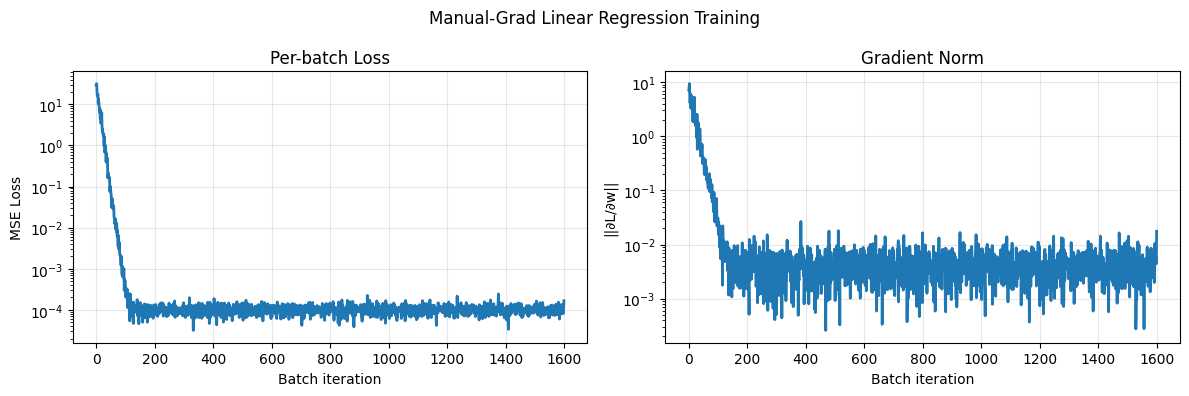


[Predict] Quick sanity check on a few points:
x=[1.0, 2.0] | y_true=-0.600 | y_pred=-0.599
x=[-1.0, 0.5] | y_true= 0.500 | y_pred= 0.500
x=[0.0, -1.0] | y_true= 7.600 | y_pred= 7.601
x=[2.5, -0.5] | y_true=10.900 | y_pred=10.902

Done. Manual-gradient linear regression recovered the true parameters.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Linear Regression from Scratch (Manual Gradients) — Live Coding Version
======================================================================

This script walks through a minimal neural-network-style linear regression
implementation where we:
  * Build the model "by hand" (parameters w, b)
  * Implement forward pass explicitly
  * Compute the MSE loss and its gradients manually (no autograd)
  * Update parameters via (mini-batch) gradient descent
  * Train on synthetic data with known ground-truth parameters

"""

# =====================================================================
# PART 0: Imports & Reproducibility
# =====================================================================

import torch
import matplotlib.pyplot as plt
from typing import Tuple, List, Generator

# Keep only the RNGs you actually use. Here we only use PyTorch.
torch.manual_seed(42)


# =====================================================================
# PART 1: Data Generation and (Optional) Visualization
# =====================================================================

def generate_synthetic_data(
    weights: torch.Tensor,
    bias: float,
    num_samples: int,
    noise_std: float = 0.01
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate linear data with Gaussian noise.

    Model:  y = X @ w + b + ε, with ε ~ N(0, noise_std^2)

    Args:
        weights: (d,) true weight vector
        bias:    scalar true intercept
        num_samples: number of samples n
        noise_std: standard deviation of additive Gaussian noise

    Returns:
        X: (n, d) feature matrix
        y: (n, 1) target vector
    """
    num_features = len(weights)

    # Features ~ N(0, I)
    X = torch.randn(num_samples, num_features)

    # Noise
    noise = noise_std * torch.randn(num_samples)

    # Linear signal + noise
    y = X @ weights + bias + noise

    # Return y as column vector (n, 1)
    return X, y.reshape(-1, 1)


def visualize_data(X: torch.Tensor, y: torch.Tensor, title: str = "Data (Optional)"):
    """
    Quick helper to visualize data (1D or 2D features only).
    Comment out or skip during live coding if not needed.
    """
    if X.shape[1] == 1:
        plt.figure(figsize=(6, 4))
        plt.scatter(X.numpy(), y.numpy(), alpha=0.5, s=20)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.show()
    elif X.shape[1] == 2:
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), y.numpy(), alpha=0.5)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title(title)
        plt.show()


# =====================================================================
# PART 2: Linear Regression (Manual Gradients)
# =====================================================================

class LinearRegressionScratch:
    """
    Linear regression "neural network" with parameters θ = (w, b),
    trained by vanilla gradient descent with manually derived gradients.

    Model:
      y_hat = X @ w + b

    Loss (MSE):
      L = (1/n) * Σ_i (y_hat_i - y_i)^2

    Gradients:
      ∂L/∂w = (2/n) * X^T (y_hat - y)
      ∂L/∂b = (2/n) * Σ_i (y_hat_i - y_i)

    In practice we often omit the factor 2 (absorbed by the learning rate).
    Here, for clarity, we keep the factor 2 in the update to match the loss.
    """

    def __init__(self, input_size: int, learning_rate: float = 0.03):
        # Parameters: initialize small random weights; zero bias
        self.w = torch.randn(input_size, 1) * 0.01   # (d, 1)
        self.b = torch.zeros(1)                      # (1,)

        # No autograd — we will compute gradients manually
        self.w.requires_grad = False
        self.b.requires_grad = False

        self.lr = learning_rate
        self.input_size = input_size

        # For monitoring during training
        self.loss_history: List[float] = []
        self.grad_norms: List[float] = []

        print(f"[Init] input_size={input_size}, lr={self.lr:.3g}")
        print(f"[Init] w^T={self.w.T.flatten().tolist()}, b={self.b.item():.4f}")

    # ---- Forward Pass ----
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Compute predictions: y_hat = X @ w + b
        """
        assert X.shape[1] == self.input_size, \
            f"Expected {self.input_size} features, got {X.shape[1]}"
        return X @ self.w + self.b

    # ---- Loss ----
    @staticmethod
    def mse_loss(y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Mean Squared Error L = mean((y_hat - y)^2).
        """
        return ((y_hat - y) ** 2).mean()

    # ---- Gradients (Manual) ----
    def compute_gradients(
        self, X: torch.Tensor, y: torch.Tensor, y_hat: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Derive ∂L/∂w and ∂L/∂b by calculus.

        With L = (1/n) Σ (y_hat - y)^2, the derivatives are:
          ∂L/∂w = (2/n) X^T (y_hat - y)
          ∂L/∂b = (2/n) Σ (y_hat - y)
        """
        n = X.shape[0]
        error = (y_hat - y)                            # (n, 1)
        grad_w = (2.0 / n) * (X.T @ error)             # (d, 1)
        grad_b = (2.0 / n) * error.sum()               # scalar tensor
        return grad_w, grad_b

    # ---- One Training Step ----
    def step(self, X: torch.Tensor, y: torch.Tensor) -> float:
        """
        One gradient descent update:
          1) forward
          2) loss
          3) gradients (manual)
          4) parameter update
        """
        # 1) forward
        y_hat = self.forward(X)

        # 2) loss
        loss = self.mse_loss(y_hat, y)
        self.loss_history.append(loss.item())

        # 3) gradients
        grad_w, grad_b = self.compute_gradients(X, y, y_hat)

        # For monitoring how "big" our update is
        self.grad_norms.append(torch.norm(grad_w).item())

        # 4) update
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b

        return loss.item()

    # ---- Helpers ----
    def get_parameters(self) -> Tuple[List[float], float]:
        return self.w.flatten().tolist(), float(self.b.item())

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        return self.forward(X)


# =====================================================================
# PART 3: Mini-batching & Training Loop
# =====================================================================

def create_mini_batches(
    X: torch.Tensor,
    y: torch.Tensor,
    batch_size: int = 32,
    shuffle: bool = True
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield (X_batch, y_batch) pairs. We stick to torch RNG for shuffling.
    """
    n = X.shape[0]
    if shuffle:
        # If you want shuffling reproducible while isolating it,
        # you can pass a dedicated generator:
        #   g = torch.Generator().manual_seed(42)
        #   idx = torch.randperm(n, generator=g)
        idx = torch.randperm(n)
    else:
        idx = torch.arange(n)

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        b = idx[start:end]
        yield X[b], y[b]


def train_model(
    model: LinearRegressionScratch,
    X: torch.Tensor,
    y: torch.Tensor,
    epochs: int = 50,
    batch_size: int = 32,
    verbose: bool = True
) -> List[float]:
    """
    Basic mini-batch GD training loop.
    We report average loss per epoch.
    """
    if verbose:
        print("\n=== Training (Manual Gradients) ===")

    epoch_avgs: List[float] = []

    for ep in range(epochs):
        total_loss = 0.0
        nb = 0

        for Xb, yb in create_mini_batches(X, y, batch_size=batch_size, shuffle=True):
            batch_loss = model.step(Xb, yb)
            total_loss += batch_loss
            nb += 1

        avg = total_loss / max(nb, 1)
        epoch_avgs.append(avg)

        if verbose and (ep == 0 or (ep + 1) % 10 == 0):
            w, b = model.get_parameters()
            print(f"Epoch {ep+1:3d} | loss={avg:.6f} | w={[f'{wi:.3f}' for wi in w]} | b={b:.3f}")

    return epoch_avgs


# =====================================================================
# PART 4: (Optional) Simple Visualization
# =====================================================================

def plot_training(model: LinearRegressionScratch, title: str = "Training (Per Batch)"):
    """
    Plot per-batch loss and gradient norms (if collected).
    """
    plt.figure(figsize=(12, 4))

    # Loss per batch
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_history, linewidth=2)
    plt.xlabel("Batch iteration")
    plt.ylabel("MSE Loss")
    plt.yscale('log')
    plt.title("Per-batch Loss")
    plt.grid(True, alpha=0.3)

    # Gradient norm per batch (optional)
    plt.subplot(1, 2, 2)
    if len(model.grad_norms) > 0:
        plt.plot(model.grad_norms, linewidth=2)
        plt.xlabel("Batch iteration")
        plt.ylabel("||∂L/∂w||")
        plt.yscale('log')
        plt.title("Gradient Norm")
        plt.grid(True, alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# =====================================================================
# PART 5: Main — End-to-end Demonstration
# =====================================================================

def main():
    """
    1) Explain the data model and generate synthetic data
    2) Define the LinearRegressionScratch class (forward, loss, gradients, step)
    3) Write a mini-batch training loop
    4) Train and compare learned parameters to ground truth
    5) (Optional) Visualize training curves
    """
    print("=" * 80)
    print("Linear Regression from Scratch (Manual Gradients)")
    print("=" * 80)

    # 1) Ground-truth parameters and data
    TRUE_W = torch.tensor([2.0, -3.4])  # d=2
    TRUE_B = 4.2
    N = 1000

    print("\n[Data] Generating synthetic data with known parameters...")
    X, y = generate_synthetic_data(TRUE_W, TRUE_B, num_samples=N, noise_std=0.01)
    print(f"[Data] X.shape={X.shape}, y.shape={y.shape}")
    print(f"[Data] True params: w={TRUE_W.tolist()}, b={TRUE_B:.3f}")

    # 2) Initialize our scratch model
    model = LinearRegressionScratch(input_size=2, learning_rate=0.03)

    # 3) Train
    print("\n[Train] Starting mini-batch gradient descent...")
    epoch_losses = train_model(model, X, y, epochs=50, batch_size=32, verbose=True)

    # 4) Inspect learned parameters vs. truth
    w_learned, b_learned = model.get_parameters()
    print("\n[Result] Learned parameters:")
    print(f"        w = {[f'{wi:.3f}' for wi in w_learned]}")
    print(f"        b = {b_learned:.3f}")
    print("[Result] Parameter errors (learned - true):")
    w_err = torch.tensor(w_learned) - TRUE_W
    b_err = b_learned - TRUE_B
    print(f"        Δw = {[f'{e:.4f}' for e in w_err.tolist()]}, Δb = {b_err:.4f}")

    # 5) (Optional) Training curves
    print("\n[Plot] Displaying per-batch loss and gradient norm...")
    plot_training(model, title="Manual-Grad Linear Regression Training")

    # 6) Quick sanity check predictions on a tiny test set
    print("\n[Predict] Quick sanity check on a few points:")
    test_X = torch.tensor([
        [1.0,  2.0],
        [-1.0, 0.5],
        [0.0, -1.0],
        [2.5, -0.5]
    ])
    true_y = test_X @ TRUE_W + TRUE_B
    pred_y = model.predict(test_X).flatten()
    for i in range(len(test_X)):
        print(f"x={test_X[i].tolist()} | y_true={true_y[i]:6.3f} | y_pred={pred_y[i]:6.3f}")

    print("\n" + "=" * 80)
    print("Done. Manual-gradient linear regression recovered the true parameters.")
    print("=" * 80)


if __name__ == "__main__":
    main()


### HW: Linear classification (softmax) manual gradient

# Lecture 2- Computation graph


In [ ]:
# # pip install cairosvg

# from google.colab import files
# import cairosvg
# from IPython.display import Image

# # Convert SVG to PNG
# cairosvg.svg2png(url='531.svg', write_to='531.png')

# # Display to verify it worked
# Image('531.png')

## 1. Leaf vs Non-Leaf Tensors 🚦

| Type of Tensor | How it is created | `.grad` populated? |
|----------------|-------------------|-------------------|
| **Leaf tensor** | Instantiated directly, *not* the result of an operation | ✅ Yes |
| **Non-leaf tensor** | Produced **from** other tensors via an operation | ❌ No |

### Key Rule 📌

Only **leaf tensors** have their `.grad` attribute populated *automatically* after calling `backward()`:

```python
# Leaf tensors
w = torch.randn(3, 1, requires_grad=True)  # Leaf
b = torch.zeros(1, requires_grad=True)     # Leaf

# Non-leaf tensors  
y_hat = X @ w + b                          # Non-leaf (result of operation)
loss = (y_hat - y).pow(2).mean()           # Non-leaf (result of operation)

loss.backward()
print(w.grad)         # ✅ Populated (leaf)
print(b.grad)         # ✅ Populated (leaf)  
print(y_hat.grad)     # ❌ None (non-leaf)
print(loss.grad)      # ❌ None (non-leaf)
```

**⚠️ Common Mistake:** Accidentally making parameters non-leaf:
```python
# ❌ WRONG - Creates new non-leaf tensor
self.w = self.w - lr * self.w.grad

# ✅ CORRECT - Keeps self.w as leaf
with torch.no_grad():
    self.w.data -= lr * self.w.grad
```

---

## 2. Parameter Updates Must Be Outside the Computation Graph 🚧

### The Problem
Parameter updates should **not** be tracked by autograd, otherwise:
- Memory usage explodes (gradient-of-gradients)
- Runtime errors when reusing modified parameters
- Unintended higher-order derivatives

### Solutions

| Method | When to Use | Example |
|--------|-------------|---------|
| `torch.no_grad()` | **Most common** - temporary disable autograd | `with torch.no_grad(): w.data -= lr * w.grad` |
| `tensor.data` | Direct access to underlying data | `w.data -= lr * w.grad` (inside no_grad) |
| `tensor.detach()` | Create new tensor without grad history | `w_no_grad = w.detach()` |

```python
# ✅ CORRECT: Parameter update outside computation graph
def training_step(self, X, y):
    # Forward pass (tracked by autograd)
    y_hat = self.forward(X)
    loss = self.compute_loss(y_hat, y)
    
    # Backward pass (builds gradients)  
    loss.backward()
    
    # Parameter update (NOT tracked by autograd)
    with torch.no_grad():
        self.w.data -= self.lr * self.w.grad
        self.b.data -= self.lr * self.b.grad
    
    return loss.item()
```

---

## 3. In-Place Operations: Handle with Care ⚠️

In-place operations (operations ending with `_`) can break the computation graph:

```python
# ❌ DANGEROUS - Can corrupt gradients
x = torch.randn(3, requires_grad=True)
y = x * 2
x.add_(1)  # In-place operation on x
loss = y.sum()
loss.backward()  # May produce incorrect gradients!

# ✅ SAFE - Create new tensor
x = torch.randn(3, requires_grad=True)
y = x * 2
x_new = x + 1  # Creates new tensor
loss = y.sum()
loss.backward()  # Correct gradients
```

**Exception:** In-place parameter updates are safe when done with `torch.no_grad()`.

---

## 4. Gradient Accumulation vs Zeroing 🔄

### Default Behavior: Gradients Accumulate
```python
loss1.backward()  # w.grad = grad1
loss2.backward()  # w.grad = grad1 + grad2 (accumulated!)
```

### Manual Gradient Management
```python
# Zero gradients before each backward pass
if self.w.grad is not None:
    self.w.grad.zero_()
    
loss.backward()  # Fresh gradients
```

### Using PyTorch Optimizers
```python
optimizer = torch.optim.SGD([w, b], lr=0.01)

# Automatic gradient zeroing
optimizer.zero_grad()  # Clear old gradients
loss.backward()        # Compute new gradients  
optimizer.step()       # Update parameters
```

---

## 5. Memory Management & Computation Graph 💾

### Graph Building
```python
# Each forward pass builds a computation graph
y1 = model(x1)  # Graph 1 created
y2 = model(x2)  # Graph 2 created (independent)

# Graphs are freed after backward()
loss1 = criterion(y1, target1)
loss1.backward()  # Graph 1 freed automatically
```

### Preventing Memory Leaks
```python
# ❌ Keeping references to intermediate results
results = []
for batch in dataloader:
    output = model(batch)
    loss = criterion(output, target)
    results.append(loss)  # Keeps computation graph in memory!
    loss.backward()

# ✅ Extract scalar values
losses = []
for batch in dataloader:
    output = model(batch)
    loss = criterion(output, target)
    losses.append(loss.item())  # Only store scalar, graph can be freed
    loss.backward()
```

---

## 6. Common Migration Pitfalls & Solutions 🐛

| Problem | Symptom | Solution |
|---------|---------|----------|
| **Non-leaf parameters** | `UserWarning: .grad attribute of non-leaf tensor` | Check parameter creation, avoid `w = w - lr * grad` |
| **In-place corruption** | `RuntimeError: leaf Variable...in-place operation` | Use `torch.no_grad()` for parameter updates |
| **Memory explosion** | GPU/RAM usage grows continuously | Don't store references to loss tensors |
| **Wrong gradients** | Model doesn't converge | Call `optimizer.zero_grad()` before each backward |
| **Graph errors** | `RuntimeError: Trying to backward through graph twice` | Don't reuse loss tensors, recreate for each step |

---

## 7. Best Practices for AutoDiff Migration ✨

### 1. **Use PyTorch Optimizers**
```python
# Instead of manual updates
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def training_step(self, X, y):
    optimizer.zero_grad()    # Clear gradients
    y_hat = self.forward(X)  # Forward pass
    loss = self.criterion(y_hat, y)
    loss.backward()          # Backward pass
    optimizer.step()         # Update parameters
    return loss.item()
```

### 2. **Validate with Manual Implementation**
Keep your manual gradient implementation to verify autograd results:
```python
# Compare gradients
manual_grad_w, manual_grad_b = compute_manual_gradients(X, y, y_hat)
loss.backward()

print("Gradient comparison:")
print(f"Manual w.grad: {manual_grad_w.flatten()}")
print(f"Auto w.grad:   {model.w.grad.flatten()}")
print(f"Match: {torch.allclose(manual_grad_w, model.w.grad)}")
```

### 3. **Debug with Small Examples**
```python
# Test autograd behavior with simple operations
x = torch.tensor([2.0], requires_grad=True)
y = x ** 2
y.backward()
print(f"dy/dx at x=2: {x.grad}")  # Should be 4.0
```

---

## 8. Quick Reference: autograd Control 🎛️

| Operation | Effect | Use Case |
|-----------|--------|----------|
| `torch.no_grad()` | Temporarily disable autograd | Parameter updates, inference |
| `tensor.detach()` | Remove tensor from graph | Create non-differentiable copy |
| `requires_grad=False` | Disable gradients permanently | Input data, constants |
| `tensor.retain_grad()` | Keep gradients for non-leaf | Debugging intermediate values |
| `torch.autograd.set_detect_anomaly(True)` | Debug gradient computation | Find NaN/inf gradients |

---

**💡 Remember:** The goal is to let PyTorch handle gradients automatically while keeping explicit control over parameter updates!

# Lecture 2-1 Linear regression with autograd


LINEAR REGRESSION: FROM MANUAL TO AUTOGRAD

1. DATA GENERATION
----------------------------------------
Generated 1000 samples
True parameters: w = [2.0, -3.4000000953674316], b = 4.2
Feature shape: torch.Size([1000, 2]), Label shape: torch.Size([1000, 1])

2. MODEL INITIALIZATION
----------------------------------------
[Manual Init] input_size=2, lr=0.03
[Manual Init] w.requires_grad=True, b.requires_grad=True
[Manual Init] Initial: w=[0.01142729539424181, -0.0007455555023625493], b=0.0000
[Autograd Init] Model architecture: LinearRegressionAutograd(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
[Autograd Init] Parameter count: 3
[Autograd Init] Initial weight: tensor([[-0.0053,  0.0103]])
[Autograd Init] Initial bias: tensor([0.])

3. GRADIENT FLOW DIAGNOSIS
----------------------------------------

=== Gradient Flow Diagnosis ===
Loss value: 53.472431
Loss requires_grad: True
Loss grad_fn: <MseLossBackward0 object at 0x7ade1a92d090>

Parameters before backward:
  l

/tmp/ipython-input-2727756165.py:382: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  f"grad_std={param.grad.std():.6e}, "
/tmp/ipython-input-2727756165.py:479: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f"b.grad: {b.grad}")  # None! (non-leaf)



--- Batch 1 ---
1. Zero gradients
   linear.weight.grad after: None
   linear.bias.grad after: None

2. Forward pass
   Predictions shape: torch.Size([32, 1])
   Predictions requires_grad: True

3. Compute loss
   Loss: 25.387756
   Loss grad_fn: <MseLossBackward0 object at 0x7ade015bf8e0>

4. Backward pass
   linear.weight.grad: mean=2.605593, norm=7.339292
   linear.bias.grad: mean=-5.454744, norm=5.454744

5. Parameter update
   linear.weight change: 0.073393
   linear.bias change: 0.054547

--- Batch 2 ---
1. Zero gradients
   linear.weight.grad before: 2.605593
   linear.bias.grad before: -5.454744
   linear.weight.grad after: None
   linear.bias.grad after: None

2. Forward pass
   Predictions shape: torch.Size([32, 1])
   Predictions requires_grad: True

3. Compute loss
   Loss: 18.847378
   Loss grad_fn: <MseLossBackward0 object at 0x7ade015bf8e0>

4. Backward pass
   linear.weight.grad: mean=-2.053023, norm=4.153923
   linear.bias.grad: mean=-7.074945, norm=7.074945

5. Param

/tmp/ipython-input-2727756165.py:102: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if self.w.grad is not None:


Final: w=[2.0000758171081543, -3.4002838134765625], b=4.1999
Final loss: 0.000103

--- Autograd Implementation ---
[Autograd Init] Model architecture: LinearRegressionAutograd(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
[Autograd Init] Parameter count: 3
[Autograd Init] Initial weight: tensor([[-0.0088, -0.0036]])
[Autograd Init] Initial bias: tensor([0.])
Final: w=[1.9998817443847656, -3.4004886150360107], b=4.2001
Final loss: 0.000102


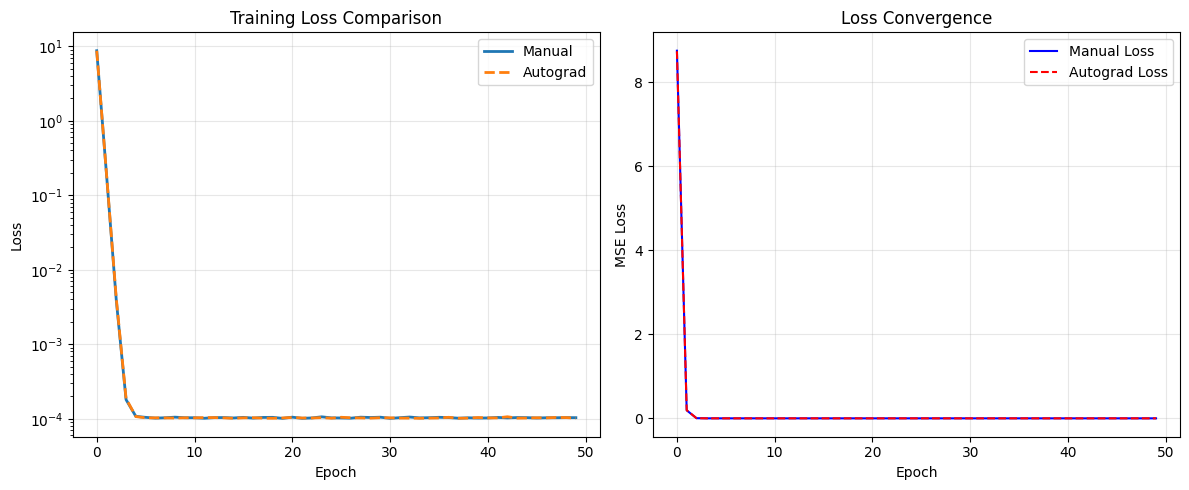


KEY TAKEAWAYS:
1. Autograd eliminates manual gradient computation
2. Always zero gradients before backward()
3. Use .item() when logging to avoid memory leaks
4. Understand leaf vs non-leaf tensors
5. Avoid in-place operations on tensors with gradients
6. Use torch.no_grad() for parameter updates

Both implementations achieve the same result!
Autograd version is cleaner and scales to complex architectures.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Linear Regression with PyTorch Autograd
===================================================================

This script demonstrates the evolution from manual gradient computation
to PyTorch's automatic differentiation.

"""

# =====================================================================
# PART 0: Initial Imports & Setup
# =====================================================================
import matplotlib.pyplot as plt
import torch
torch.manual_seed(42)


# =====================================================================
# PART 1: Data Generation (Manual Implementation Foundation)
# =====================================================================

from typing import Tuple, List

def generate_synthetic_data(
    weights: torch.Tensor,
    bias: float,
    num_samples: int,
    noise_std: float = 0.01
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate linear data with Gaussian noise.
    - Same data generation ensures fair comparison
    - Noise makes the problem realistic
    - We know ground truth for validation
    """
    num_features = len(weights)

    # Generate random features from standard normal distribution
    X = torch.randn(num_samples, num_features)

    # Add Gaussian noise to make problem realistic
    noise = noise_std * torch.randn(num_samples)

    # Linear relationship: y = X @ w + b + noise
    y = X @ weights + bias + noise

    # Reshape y to column vector for consistency**************
    return X, y.reshape(-1, 1)


# =====================================================================
# PART 2A: Manual Implementation (Fixed for Autograd Compatibility)
# =====================================================================

class LinearRegressionManual:
    """
    Manual gradient implementation that's compatible with autograd experiments.

    [KEY INSIGHT]: This version shows what autograd does behind the scenes.
    """

    def __init__(self, input_size: int, learning_rate: float = 0.03):
        # Initialize parameters as leaf tensors with requires_grad=True
        # This allows us to accumulate gradients even in manual implementation
        self.w = torch.randn(input_size, 1, requires_grad=True) * 0.01#*********
        self.b = torch.zeros(1, requires_grad=True)#**************

        # [IMPORTANT]: These are now leaf tensors that can accumulate gradients

        self.lr = learning_rate
        self.input_size = input_size

        print(f"[Manual Init] input_size={input_size}, lr={self.lr:.3g}")
        print(f"[Manual Init] w.requires_grad={self.w.requires_grad}, b.requires_grad={self.b.requires_grad}")
        print(f"[Manual Init] Initial: w={self.w.data.flatten().tolist()}, b={self.b.item():.4f}")

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Compute predictions: y_hat = X @ w + b"""
        return X @ self.w + self.b

    def compute_loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """MSE Loss"""
        return ((y_hat - y) ** 2).mean()

    def manual_backward(self, X: torch.Tensor, y: torch.Tensor, y_hat: torch.Tensor):
        """
        Manually compute gradients and store them.

        This is what autograd does automatically!
        """
        n = X.shape[0]
        error = (y_hat - y)

        # Manually compute gradients using calculus
        # For MSE: dL/dw = (2/n) * X^T @ (y_hat - y)
        grad_w = (2.0 / n) * (X.T @ error)
        grad_b = (2.0 / n) * error.sum()

        # Store gradients in .grad attribute (mimicking autograd)
        if self.w.grad is not None:
            self.w.grad.zero_()
        self.w.grad = grad_w

        if self.b.grad is not None:
            self.b.grad.zero_()

        #  FIX: Ensure grad_b has the same shape as self.b
        self.b.grad = grad_b.reshape(self.b.shape)

    def step(self, X: torch.Tensor, y: torch.Tensor) -> float:
        """One training step with manual gradients"""
        # Forward
        y_hat = self.forward(X)
        loss = self.compute_loss(y_hat, y)

        # Backward (manual)
        self.manual_backward(X, y, y_hat)

        # Update parameters using: self.w.data -= self.lr * self.w.grad
        # ❌ NO torch.no_grad() - this modifies leaf variables in-place
        # Use torch.no_grad() and .data to avoid autograd issues
        with torch.no_grad():
            self.w.data -= self.lr * self.w.grad
            self.b.data -= self.lr * self.b.grad

        return loss.item()


# =====================================================================
# PART 2B: Autograd Implementation
# =====================================================================

# [NEW IMPORTS]: PyTorch's neural network module
import torch.nn as nn
# Why nn?: Provides pre-built layers and base classes for neural networks
# - nn.Module: Base class for all neural network modules
# - nn.Linear: Fully connected layer (what we're implementing manually)
# - nn.MSELoss: Mean squared error loss function



class LinearRegressionAutograd(nn.Module):
    """
    Linear regression using PyTorch's nn.Module.
    """

    def __init__(self, input_size: int):
        # [COMMON MISTAKE #1]: Forgetting super().__init__()
        # Uncomment to see error: "cannot assign module before Module.__init__()"
        # super().__init__() calls the constructor of the parent class, torch.nn.Module
        # self.linear = nn.Linear(input_size, 1)  # This would fail!
        super(LinearRegressionAutograd, self).__init__()

        # nn.Linear creates weight and bias with requires_grad=True automatically
        # Linear layer: output = input @ weight.T + bias
        self.linear = nn.Linear(input_size, 1)

        # Initialize to match manual version for fair comparison
        with torch.no_grad():
            self.linear.weight.normal_(0, 0.01)
            self.linear.bias.zero_()
        # Note that now Model ONLY defines architecture and forward pass, and No learning rate (goes to OPTIMIZER), no update logic
        #        Now, you can easily change optimizers without touching the model
                # optimizer1 = optim.SGD(model.parameters(), lr=0.01)
                # optimizer2 = optim.Adam(model.parameters(), lr=0.001)
        # So The model doesn't need to know HOW it's being optimized, just HOW to compute outputs->more modular and reusable code.

        # [DEBUGGING TIP]: Always check initialization
        print(f"[Autograd Init] Model architecture: {self}")
        print(f"[Autograd Init] Parameter count: {sum(p.numel() for p in self.parameters())}")
        print(f"[Autograd Init] Initial weight: {self.linear.weight.data}")
        print(f"[Autograd Init] Initial bias: {self.linear.bias.data}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass builds computation graph.

        [KEY CONCEPT]: This is where PyTorch traces operations
        for automatic differentiation.
        """
        # [DEBUGGING]: Uncomment to see computation graph building
        # print(f"Forward: input.requires_grad={x.requires_grad}")

        return self.linear(x)

    def get_parameters(self) -> Tuple[List[float], float]:
        """Extract parameters for comparison"""
        with torch.no_grad():
            weights = self.linear.weight.flatten().tolist()
            bias = float(self.linear.bias.item())
        return weights, bias


# =====================================================================
# PART 3: Training Functions
# =====================================================================
# FROM BEFORE
def train_manual(
    model: LinearRegressionManual,
    X: torch.Tensor,
    y: torch.Tensor,
    epochs: int = 50,
    batch_size: int = 32,
    verbose: bool = True #Explain that we did not use verbose last time!
) -> List[float]:
    """Training with manual gradients"""

    if verbose:
        print("\n=== Training (Manual Gradients) ===")

    epoch_losses = []
    n_samples = X.shape[0]

    for epoch in range(epochs):
        # Shuffle data manually
        indices = torch.randperm(n_samples)
        total_loss = 0.0
        num_batches = 0

        # Manual mini-batching
        for start_idx in range(0, n_samples, batch_size):
            end_idx = min(start_idx + batch_size, n_samples)
            batch_indices = indices[start_idx:end_idx]

            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            loss = model.step(batch_X, batch_y)
            total_loss += loss
            num_batches += 1

        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)

        if verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
            print(f"Epoch {epoch+1:3d} | loss={avg_loss:.6f}")

    return epoch_losses


# [NEW IMPORTS]: PyTorch's data utilities and optimizers
from torch.utils.data import DataLoader, TensorDataset
# Why DataLoader?: Handles batching, shuffling, and parallel data loading
# Why TensorDataset?: Wraps tensors into a dataset for DataLoader
# Without TensorDataset, you would have to manually create your own custom Dataset class to
#            keep X_train and y_train synchronized, which is much more work for such a common task.
import torch.optim as optim
# Why optim?: Provides optimization algorithms (SGD, Adam, etc.)
# Instead of manually updating parameters, optimizers handle it

def train_autograd(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
    epochs: int = 50,
    batch_size: int = 32,
    learning_rate: float = 0.03,
    verbose: bool = True,
    debug_mode: bool = False
) -> List[float]:
    """
    Training with autograd - includes debugging features.

     Toggle debug_mode to show internals
    """

    # Create dataset and dataloader for automatic batching
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Loss function - PyTorch's built-in MSE
    criterion = nn.MSELoss()

    # Optimizer - handles parameter updates
    # [COMMON MISTAKE #2]: Using model.parameters instead of model.parameters()
    # optimizer = optim.SGD(model.parameters, lr=learning_rate)  # WRONG!
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if verbose:
        print("\n=== Training (Autograd) ===")
        print(f"Optimizer: {optimizer}")
        print(f"Loss function: {criterion}")

    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        # DataLoader automatically handles batching and shuffling
        for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
            # [COMMON MISTAKE #3]: Forgetting to zero gradients
            # Comment out the next line to see gradient accumulation!
            optimizer.zero_grad()

            # Forward pass - autograd tracks operations
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            # [DEBUGGING]: Show computation graph
            if debug_mode and epoch == 0 and batch_idx == 0:
                print(f"\n[DEBUG] First batch:")
                print(f"  predictions.requires_grad: {predictions.requires_grad}")
                print(f"  loss.requires_grad: {loss.requires_grad}")
                print(f"  loss.grad_fn: {loss.grad_fn}")

            # Backward pass - autograd computes all gradients
            loss.backward()

            # [DEBUGGING]: Check gradients
            if debug_mode and epoch == 0 and batch_idx == 0:
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f"  {name}.grad: mean={param.grad.mean():.6f}, std={param.grad.std():.6f}")

            # [COMMON MISTAKE #4]: Modifying parameters without no_grad
            # model.linear.weight.data += 0.001  # This is OK
            # model.linear.weight += 0.001  # This would break the graph!

            # Update parameters using optimizer
            optimizer.step()

            # [IMPORTANT]: Use .item() to get Python number and avoid memory leak
            #      (by not accumulating the computational graph with each iteration that is attached to loss,
            #                          thus garbage collector will remove them while keeping the total_loss.)
            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)

        if verbose and (epoch == 0 or (epoch + 1) % 10 == 0):
            weights, bias = model.get_parameters()
            print(f"Epoch {epoch+1:3d} | loss={avg_loss:.6f} | "
                  f"w={[f'{w:.3f}' for w in weights]} | b={bias:.3f}")

    return epoch_losses


# =====================================================================
# PART 4: Debugging Utilities
# =====================================================================

def diagnose_gradient_flow(model: nn.Module, X: torch.Tensor, y: torch.Tensor):
    """
    Diagnose gradient flow issues in a model.

    [USE CASE]: When gradients are None or zero
    """
    print("\n=== Gradient Flow Diagnosis ===")

    # Set model to training mode
    model.train()

    # from before:
    criterion = nn.MSELoss()

    # Forward pass with small batch
    output = model(X[:10])
    loss = criterion(output, y[:10])

    print(f"Loss value: {loss.item():.6f}")
    print(f"Loss requires_grad: {loss.requires_grad}")
    print(f"Loss grad_fn: {loss.grad_fn}")

    # Check parameters before backward
    print("\nParameters before backward:")
    for name, param in model.named_parameters():
        print(f"  {name}: shape={param.shape}, requires_grad={param.requires_grad}, "
              f"grad={'None' if param.grad is None else 'exists'}")

    # Backward pass
    loss.backward()

    # Check gradients after backward
    print("\nGradients after backward:")
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"  {name}: grad_mean={param.grad.mean():.6e}, "
                  f"grad_std={param.grad.std():.6e}, "
                  f"grad_norm={param.grad.norm():.6e}")
        else:
            print(f"  {name}: grad=None [PROBLEM!]")


def demonstrate_common_mistakes():
    """
    Live demonstration of common autograd mistakes.

    Run through each mistake interactively
    """
    print("\n" + "="*80)
    print("COMMON AUTOGRAD MISTAKES AND HOW TO DEBUG THEM")
    print("="*80)

    # Mistake 1: In-place operations
    print("\n1. IN-PLACE OPERATIONS")
    print("-" * 40)
    try:
        x = torch.tensor([1.0, 2.0], requires_grad=True)
        y = x * 2
        print(f"Original: x={x.data}, y={y.data}")

        # This would cause an error:
        # y += 1  # RuntimeError: a leaf Variable that requires grad is being used in an in-place operation

        # Correct way:
        y = y + 1
        print(f"After y = y + 1: y={y.data}")
        print("✓ Solution: Use y = y + 1 instead of y += 1")
    except RuntimeError as e:
        print(f"✗ Error: {e}")

    # Mistake 2: Not zeroing gradients
    print("\n2. GRADIENT ACCUMULATION")
    print("-" * 40)
    # from before:
    model = nn.Linear(1, 1)
    x = torch.tensor([[1.0]], requires_grad=True)
    y_true = torch.tensor([[2.0]])

    # First backward
    y_pred = model(x)
    loss1 = (y_pred - y_true) ** 2
    loss1.backward()
    grad1 = model.weight.grad.clone()
    print(f"After 1st backward: grad={grad1.item():.4f}")

    # Second backward WITHOUT zero_grad
    y_pred = model(x)
    loss2 = (y_pred - y_true) ** 2
    loss2.backward()
    grad2 = model.weight.grad.clone()
    print(f"After 2nd backward: grad={grad2.item():.4f} (accumulated!)")

    # Correct way
    model.zero_grad()
    y_pred = model(x)
    loss3 = (y_pred - y_true) ** 2
    loss3.backward()
    grad3 = model.weight.grad.clone()
    print(f"After zero_grad + backward: grad={grad3.item():.4f} (correct)")

    # Mistake 3: Detachment issues
    print("\n3. DETACHMENT AND COMPUTATION GRAPH")
    print("-" * 40)
    x = torch.tensor([1.0], requires_grad=True)
    y = x * 2
    z = y.detach() * 3  # Detached from graph
    w = z * x  # x is still in graph, but path through z is broken
    # This is used to treat a tensor as a fixed constant or to convert it to NumPy (e.g. for plotting)

    print(f"x.requires_grad: {x.requires_grad}")
    print(f"y.requires_grad: {y.requires_grad}")
    print(f"z.requires_grad: {z.requires_grad}")
    print(f"w.requires_grad: {w.requires_grad}")

    w.backward()
    print(f"x.grad: {x.grad}")  # Only gets gradient from direct path

    # Mistake 4: Leaf vs non-leaf tensors
    print("\n4. LEAF VS NON-LEAF TENSORS")
    print("-" * 40)
    # Leaf tensor (created by user), e.g.  model's parameters (e.g., model.weight, model.bias) or the input data
    a = torch.tensor([1.0], requires_grad=True)
    print(f"a.is_leaf: {a.is_leaf}, a.requires_grad: {a.requires_grad}")

    # Non-leaf tensor (result of operation)
    b = a * 2
    print(f"b.is_leaf: {b.is_leaf}, b.requires_grad: {b.requires_grad}")

    # Only leaf tensors accumulate gradients by default
    c = b * 3
    c.backward()
    # backward() Computes gradients for leaf nodes, then frees the gradients of intermediate tensors to save memory.
    print(f"a.grad: {a.grad}")  # Has gradient
    print(f"b.grad: {b.grad}")  # None! (non-leaf)

    # To keep gradients for non-leaf:
    a.grad.zero_()
    b = a * 2
    b.retain_grad()  # Tell PyTorch to keep this gradient
    c = b * 3
    c.backward()
    print(f"With retain_grad() - b.grad: {b.grad}")


def debug_training_loop(model: nn.Module, dataloader: DataLoader, num_batches: int = 3):
    """
    Step-by-step debugging of a training loop.

    [INTERACTIVE DEBUGGING]: Use this to understand what happens at each step
    """
    print("\n" + "="*80)
    print("STEP-BY-STEP TRAINING LOOP DEBUGGING")
    print("="*80)

    # from before:
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        print(f"\n--- Batch {batch_idx + 1} ---")

        # Step 1: Zero gradients
        print("1. Zero gradients")
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"   {name}.grad before: {param.grad.mean().item():.6f}")

        optimizer.zero_grad()

        for name, param in model.named_parameters():
            print(f"   {name}.grad after: {param.grad}")

        # Step 2: Forward pass
        print("\n2. Forward pass")
        predictions = model(X_batch)
        print(f"   Predictions shape: {predictions.shape}")
        print(f"   Predictions requires_grad: {predictions.requires_grad}")

        # Step 3: Compute loss
        print("\n3. Compute loss")
        loss = criterion(predictions, y_batch)
        print(f"   Loss: {loss.item():.6f}")
        print(f"   Loss grad_fn: {loss.grad_fn}")

        # Step 4: Backward pass
        print("\n4. Backward pass")
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"   {name}.grad: mean={param.grad.mean().item():.6f}, "
                      f"norm={param.grad.norm().item():.6f}")

        # Step 5: Parameter update
        print("\n5. Parameter update")
        param_before = {name: param.clone() for name, param in model.named_parameters()}

        optimizer.step()

        for name, param in model.named_parameters():
            change = (param - param_before[name]).norm().item()
            print(f"   {name} change: {change:.6f}")


# =====================================================================
# PART 5: Comparison and Visualization
# =====================================================================



def compare_implementations(verbose: bool = True):
    """
    Side-by-side comparison of manual vs autograd implementations.

    [DEMONSTRATION]: Shows both achieve same results
    """
    print("\n" + "="*80)
    print("COMPARING MANUAL VS AUTOGRAD IMPLEMENTATIONS")
    print("="*80)

    # from before:
    TRUE_W = torch.tensor([2.0, -3.4])
    TRUE_B = 4.2
    X, y = generate_synthetic_data(TRUE_W, TRUE_B, num_samples=1000, noise_std=0.01)

    print(f"\nTrue parameters: w={TRUE_W.tolist()}, b={TRUE_B}")

    # Train manual version
    print("\n--- Manual Implementation ---")
    model_manual = LinearRegressionManual(input_size=2)
    losses_manual = train_manual(model_manual, X, y, epochs=50, verbose=False)

    with torch.no_grad():
        w_manual = model_manual.w.flatten().tolist()
        b_manual = model_manual.b.item()
    print(f"Final: w={w_manual}, b={b_manual:.4f}")
    print(f"Final loss: {losses_manual[-1]:.6f}")

    # Train autograd version
    print("\n--- Autograd Implementation ---")
    model_auto = LinearRegressionAutograd(input_size=2)
    losses_auto = train_autograd(model_auto, X, y, epochs=50, verbose=False)

    w_auto, b_auto = model_auto.get_parameters()
    print(f"Final: w={w_auto}, b={b_auto:.4f}")
    print(f"Final loss: {losses_auto[-1]:.6f}")

    # Plot comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses_manual, label='Manual', linewidth=2)
    plt.plot(losses_auto, label='Autograd', linewidth=2, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # from before:
    epochs = range(len(losses_manual))
    plt.plot(epochs, losses_manual, 'b-', label='Manual Loss')
    plt.plot(epochs, losses_auto, 'r--', label='Autograd Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# =====================================================================
# PART 6: Main Demonstration
# =====================================================================

def main():
    print("="*80)
    print("LINEAR REGRESSION: FROM MANUAL TO AUTOGRAD")
    print("="*80)

    # from before:
    TRUE_W = torch.tensor([2.0, -3.4])
    TRUE_B = 4.2
    N = 1000

    print("\n1. DATA GENERATION")
    print("-" * 40)
    X, y = generate_synthetic_data(TRUE_W, TRUE_B, num_samples=N, noise_std=0.01)
    print(f"Generated {N} samples")
    print(f"True parameters: w = {TRUE_W.tolist()}, b = {TRUE_B}")
    print(f"Feature shape: {X.shape}, Label shape: {y.shape}")

    # Create models
    print("\n2. MODEL INITIALIZATION")
    print("-" * 40)
    model_manual = LinearRegressionManual(input_size=2)
    model_auto = LinearRegressionAutograd(input_size=2)

    # Demonstrate gradient flow diagnosis
    print("\n3. GRADIENT FLOW DIAGNOSIS")
    print("-" * 40)
    diagnose_gradient_flow(model_auto, X, y)

    # Show common mistakes
    demonstrate_common_mistakes()

    # Debug training loop
    print("\n4. TRAINING LOOP DEBUGGING")
    print("-" * 40)
    # from before:
    dataset = TensorDataset(X[:100], y[:100])  # Small subset
    debug_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    debug_model = LinearRegressionAutograd(input_size=2)
    debug_training_loop(debug_model, debug_loader, num_batches=2)

    # Compare implementations
    print("\n5. FULL TRAINING COMPARISON")
    print("-" * 40)
    compare_implementations()

    # Summary
    print("\n" + "="*80)
    print("KEY TAKEAWAYS:")
    print("="*80)
    print("1. Autograd eliminates manual gradient computation")
    print("2. Always zero gradients before backward()")
    print("3. Use .item() when logging to avoid memory leaks")
    print("4. Understand leaf vs non-leaf tensors")
    print("5. Avoid in-place operations on tensors with gradients")
    print("6. Use torch.no_grad() for parameter updates")
    print("\nBoth implementations achieve the same result!")
    print("Autograd version is cleaner and scales to complex architectures.")
    print("="*80)


# =====================================================================
# PART 7: Advanced Topics (Bonus)
# =====================================================================

# [NEW IMPORT]: For advanced features (optional)
from typing import Optional
# Why Optional?: For parameters that might be None

def advanced_autograd_concepts():
    """
    Advanced concepts for interested students.

    [OPTIONAL]: Cover if time permits
    """
    print("\n" + "="*80)
    print("ADVANCED AUTOGRAD CONCEPTS")
    print("="*80)

    # Gradient checkpointing
    print("\n1. GRADIENT CHECKPOINTING")
    print("-" * 40)
    print("Used to trade computation for memory in very deep networks")

    # Higher-order gradients
    print("\n2. HIGHER-ORDER GRADIENTS")
    print("-" * 40)
    x = torch.tensor([2.0], requires_grad=True)
    y = x ** 3  # y = x^3

    # First derivative: dy/dx = 3x^2
    first_grad = torch.autograd.grad(y, x, create_graph=True)[0]
    print(f"First derivative at x=2: {first_grad.item()} (expected: 12)")

    # Second derivative: d²y/dx² = 6x
    second_grad = torch.autograd.grad(first_grad, x)[0]
    print(f"Second derivative at x=2: {second_grad.item()} (expected: 12)")

    # Custom autograd functions
    print("\n3. CUSTOM AUTOGRAD FUNCTIONS")
    print("-" * 40)
    print("You can define custom forward/backward passes")
    print("Useful for implementing novel operations")

    # [NEW IMPORT]: Only if discussing custom autograd
    # from torch.autograd import Function
    # Why Function?: Base class for custom autograd operations


if __name__ == "__main__":
    main()

    # Uncomment for advanced topics
    # advanced_autograd_concepts()

# Lecture 3-1 High-D Linear Regression Weight decay

HIGH-DIMENSIONAL MULTI-OUTPUT LINEAR REGRESSION
Empirical output correlations (3×3 block):
tensor([[ 1.0000, -0.3950, -0.0497],
        [-0.3950,  1.0000,  0.2954],
        [-0.0497,  0.2954,  1.0000]])
Weight sparsity: 90.00%

COMMON MISTAKES IN HIGH-DIMENSIONAL REGRESSION

1. NO REGULARIZATION WITH HIGH DIMENSIONS
----------------------------------------

[Model Init] Architecture: Linear(1000 → 5)
[Model Init] Parameters: 5,005
[Model Init] Weight norm: 0.7021
Training without regularization...
Epoch 0: Loss=1.2003, Weight norm=0.8
Epoch 9: Loss=0.0000, Weight norm=0.9
→ Weight explosion! Need regularization in high dimensions.

2. LOSS SHAPE MISTAKES
----------------------------------------
Wrong loss (sum): 325.23
Correct loss (mean): 2.0327
→ Use mean() to make loss independent of batch size!

3. FORGETTING FEATURE SCALING
----------------------------------------
Feature stds: tensor([1.0058e+03, 8.3637e-01, 8.6264e-01, 1.0076e+00, 1.0590e+00, 9.9371e-01,
        1.0882e+00, 9.07

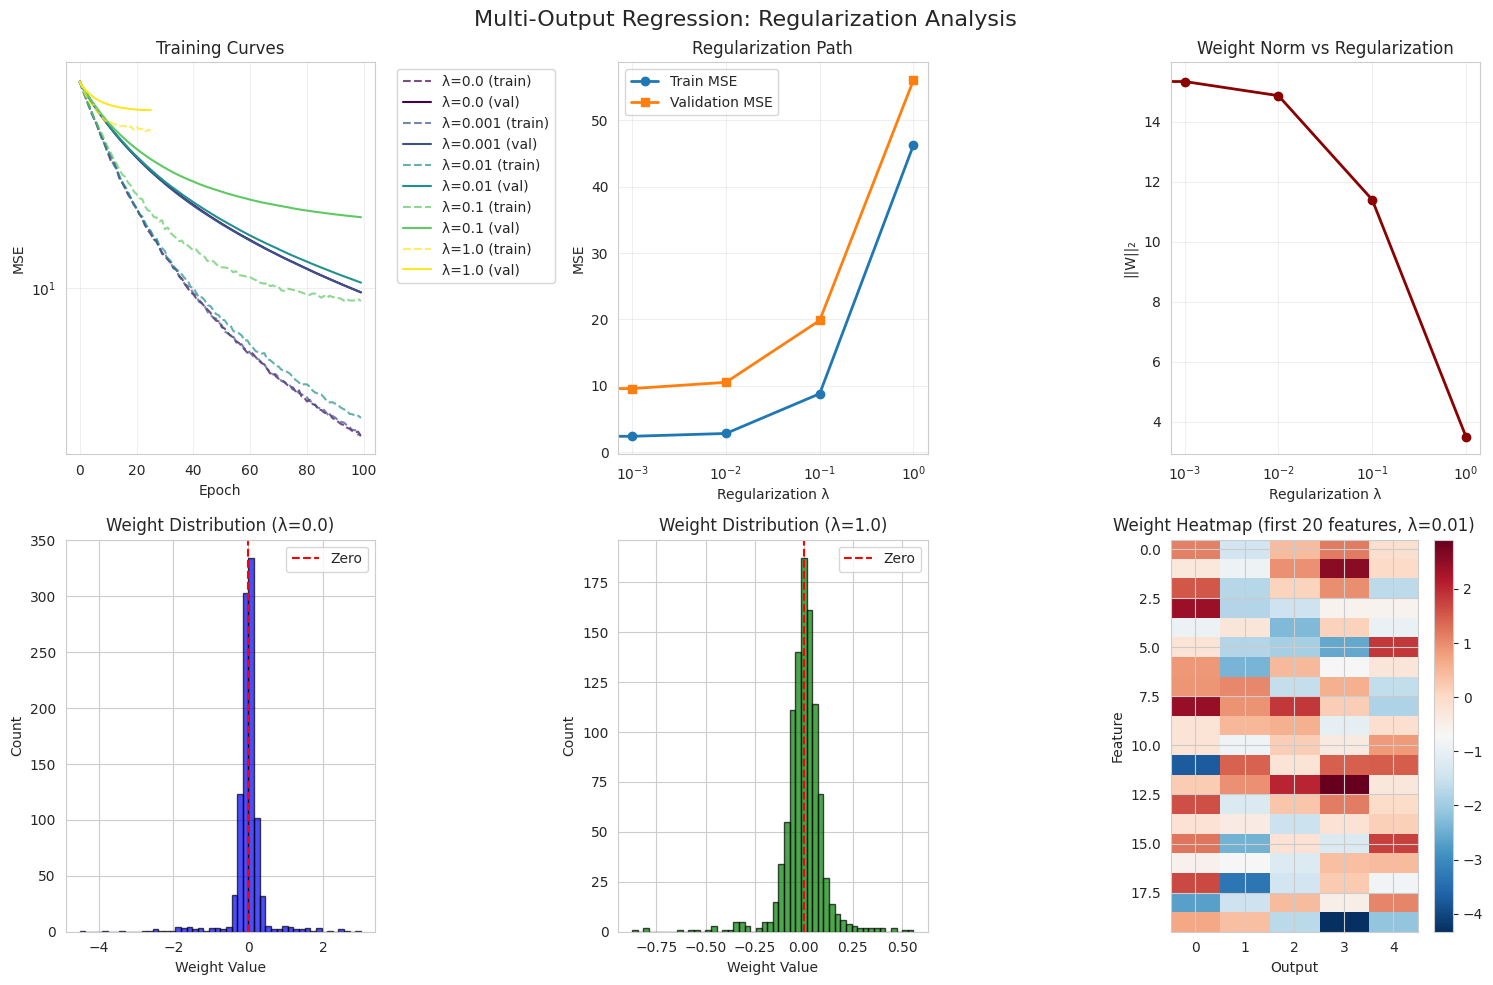


ADVANCED REGULARIZATION TECHNIQUES

1. ADAPTIVE REGULARIZATION
----------------------------------------
- Different λ for different parameters
- Useful when parameters have different scales/importance
- Implementation: Use parameter groups in optimizer

[Model Init] Architecture: Linear(10 → 5)
[Model Init] Parameters: 55
[Model Init] Weight norm: 0.0730

2. GROUP LASSO
----------------------------------------
- Regularizes groups of parameters together
- Useful for selecting features in groups
- Example: All coefficients for one original feature

3. DROPOUT FOR LINEAR MODELS
----------------------------------------
- Can apply dropout to inputs in linear regression
- Acts as a form of regularization
- Different from weight decay but can be complementary

KEY TAKEAWAYS:
1. High dimensions require regularization to prevent overfitting
2. Multi-output regression can leverage task correlations
3. Weight decay (L2) shrinks weights smoothly
4. L1 regularization promotes sparsity
5. Always 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
High-Dimensional Multi-Output Linear Regression with Weight Decay
================================================================

This script extends basic linear regression to:
1. Handle high-dimensional inputs (d >> n scenario)
2. Predict multiple outputs simultaneously (multi-task learning)
3. Apply L2 regularization (weight decay) to prevent overfitting

- Start with multi-output extension
- Introduce regularization concepts
- Common pitfalls in high dimensions
- Compare different regularization strengths

"""

# =====================================================================
# PART 0: Core Imports (from before)
# =====================================================================

# From before: PyTorch core for tensors and autograd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
import numpy as np
torch.manual_seed(42)
np.random.seed(42)  # [NEW]: Coordinate both PyTorch and NumPy randomness


# =====================================================================
# PART 1: Data Generation for Multi-Output Regression
# =====================================================================

def generate_multioutput_data(
    n_samples: int = 1_000,
    n_features: int = 100,
    n_outputs: int = 5,
    n_informative: int = 10,
    noise_std: float = 0.1,
    correlation_strength: float = 0.5,
    device: str = "cpu"
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Multi-output regression data with *explicit* output covariance Σ.

    Model:   y | X  ~  N( X W + b ,  Σ )
    Σ = σ² [ (1−ρ) I  +  ρ 11ᵀ ]   — equi-correlated.
    """
    # --- 1. Design matrix -----------------------------------------------------
    X = torch.randn(n_samples, n_features, device=device)          # 𝒩(0,1)

    # --- 2. Sparse ground-truth weights --------------------------------------
    true_W = torch.zeros(n_features, n_outputs, device=device)
    true_W[:n_informative] = 2.0 * torch.randn(n_informative, n_outputs, device=device)

    # --- 4. Bias --------------------------------------------------------------
    true_b = 0.5 * torch.randn(n_outputs, device=device)

    # --- 5. Output covariance  Σ ---------------------------------------------
    ρ   = correlation_strength
    eye = torch.eye(n_outputs, device=device)
    ones= torch.ones(n_outputs, n_outputs, device=device)
    Sigma = noise_std**2 * ((1-ρ) * eye + ρ * ones)          # equi-correlated
    L = torch.linalg.cholesky(Sigma)                         # Σ = L Lᵀ

    # --- 6. Sample ε ~ N(0, Σ) row-wise ---------------------------------------
    eps = torch.randn(n_samples, n_outputs, device=device) @ L.T   # (n×d)

    # --- 7. Outputs -----------------------------------------------------------
    y = X @ true_W + true_b + eps

    # --- 8. Quick sanity checks ----------------------------------------------
    corr = torch.corrcoef(y.T)
    sparsity = (true_W == 0).float().mean().item()
    print(f"Empirical output correlations (3×3 block):\n{corr[:3, :3]}")
    print(f"Weight sparsity: {sparsity:.2%}")

    return X, y, true_W

# =====================================================================
# PART 2: Multi-Output Model with Regularization
# =====================================================================

class MultiOutputLinearRegression(nn.Module):
    """
    Multi-output linear regression with regularization options.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        init_scale: float = 0.01,
        bias: bool = True
    ):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)

        # Proper initialization is crucial in high dimensions
        # Default PyTorch init might be too large
        with torch.no_grad():
            self.linear.weight.normal_(0, init_scale)
            if bias and self.linear.bias is not None:
                self.linear.bias.zero_()

        print(f"\n[Model Init] Architecture: Linear({input_dim} → {output_dim})")
        print(f"[Model Init] Parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"[Model Init] Weight norm: {self.linear.weight.norm():.4f}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for multi-output prediction.

        [COMMON MISTAKE]: Forgetting that output is now (batch_size, n_outputs)
        instead of (batch_size, 1)
        """
        return self.linear(x)

    def get_weight_stats(self) -> Dict[str, float]:
        """Get statistics about learned weights - useful for debugging."""
        with torch.no_grad():
            W = self.linear.weight  # shape: (output_dim, input_dim)
            stats = {
                'weight_norm': W.norm().item(),
                'weight_mean': W.mean().item(),
                'weight_std': W.std().item(),
                'weight_max': W.abs().max().item(),
                'weight_sparsity': (W.abs() < 0.01).sum().item() / W.numel()#number of elements
            }
        return stats


# =====================================================================
# PART 3: Custom Loss with Regularization
# =====================================================================

class RegularizedMultiOutputLoss(nn.Module):
    """
    MSE loss with multiple regularization options for multi-output regression.

    Different regularization strategies:
    1. L2 (Ridge): Shrinks all weights equally
    2. L1 (Lasso): Promotes sparsity
    3. Elastic Net: Combination of L1 and L2
    """

    def __init__(
        self,
        l2_lambda: float = 0.0,
        l1_lambda: float = 0.0
    ):
        super().__init__()
        self.l2_lambda = l2_lambda
        self.l1_lambda = l1_lambda

        # [DEBUGGING]: Always log hyperparameters
        print(f"\n[Loss Init] L2 lambda: {l2_lambda}, L1 lambda: {l1_lambda}")

    def forward(
        self,
        predictions: torch.Tensor,
        targets: torch.Tensor,
        model: nn.Module
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        """
        Compute regularized loss with detailed breakdown.

        [DEBUGGING TIP]: Return loss components separately for analysis
        """


        # Base MSE loss - now across multiple outputs
        mse_loss = (predictions - targets).pow(2).mean()

        # Regularization terms
        l2_reg = 0.0
        l1_reg = 0.0

        # [IMPORTANT]: Only regularize weights, not biases (common practice)
        for name, param in model.named_parameters():
            if 'weight' in name:
                if self.l2_lambda > 0:
                    l2_reg += param.pow(2).sum()
                if self.l1_lambda > 0:
                    l1_reg += param.abs().sum()

        # Total loss
        total_loss = mse_loss + self.l2_lambda * l2_reg + self.l1_lambda * l1_reg

        # [DEBUGGING]: Track individual components
        components = {
            'mse': mse_loss.item(),
            'l2_reg': l2_reg.item() if isinstance(l2_reg, torch.Tensor) else l2_reg,
            'l1_reg': l1_reg.item() if isinstance(l1_reg, torch.Tensor) else l1_reg,
            'total': total_loss.item()
        }

        return total_loss, components


# =====================================================================
# PART 4: Training with Regularization (Introducing Validation Sets)
# =====================================================================

def train_with_regularization(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor, #VALIDATION SET
    y_val: torch.Tensor,
    l2_lambda: float = 0.01,
    l1_lambda: float = 0.0,
    epochs: int = 100,
    batch_size: int = 64,
    learning_rate: float = 0.01,
    verbose: bool = True
) -> Dict[str, List[float]]:
    """
    Train model with regularization and track metrics.

    [NEW CONCEPT - VALIDATION SET]:
    We now split our data into THREE sets:
    1. Training set: Used to update model parameters
    2. Validation set: Used to tune hyperparameters and detect overfitting
    3. Test set: Final evaluation (not used during training)

    The validation set helps us:
    - Detect overfitting early
    - Choose optimal hyperparameters (like lambda)
    - Decide when to stop training

    [COMMON PITFALL]: In high dimensions with small samples,
    validation loss might be much higher than training loss!
    """

    # From before: Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Custom loss with regularization
    criterion = RegularizedMultiOutputLoss(l2_lambda=l2_lambda, l1_lambda=l1_lambda)

    # From before: optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'train_mse': [], 'val_mse': [],
        'weight_norm': [], 'gradient_norm': []
    }

    if verbose:
        print(f"\n=== Training with L2={l2_lambda}, L1={l1_lambda} ===")

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_stats = {'loss': 0, 'mse': 0, 'batches': 0}

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            # Forward pass
            predictions = model(batch_X)
            loss, components = criterion(predictions, batch_y, model)

            # [DEBUGGING]: Check for NaN/Inf
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Loss is {loss.item()} at epoch {epoch}")
                print(f"Predictions stats: mean={predictions.mean():.4f}, std={predictions.std():.4f}")
                break

            # Backward pass
            loss.backward()

            # [GRADIENT DEBUGGING]: Track gradient magnitude
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5

            # From before: Step optimizer
            optimizer.step()

            epoch_stats['loss'] += loss.item()
            epoch_stats['mse'] += components['mse']
            epoch_stats['batches'] += 1

        # [NEW CONCEPT - VALIDATION PHASE]:
        # After each epoch, we evaluate on validation set WITHOUT updating weights
        # This gives us an unbiased estimate of model performance
        model.eval()  # Sets model to evaluation mode (important for dropout/batchnorm later)
        with torch.no_grad():  # No gradients needed for validation
            val_pred = model(X_val)
            val_loss, val_components = criterion(val_pred, y_val, model)

            # [NEW]: Per-output validation metrics
            # Useful to see which outputs are harder to predict
            per_output_mse = (val_pred - y_val).pow(2).mean(dim=0)

        # Record metrics
        avg_train_loss = epoch_stats['loss'] / epoch_stats['batches']
        avg_train_mse = epoch_stats['mse'] / epoch_stats['batches']

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss.item())
        history['train_mse'].append(avg_train_mse)
        history['val_mse'].append(val_components['mse'])
        history['weight_norm'].append(model.linear.weight.norm().item())
        history['gradient_norm'].append(total_norm)

        # [NEW TECHNIQUE - EARLY STOPPING]:
        # If validation loss hasn't improved in 20 epochs, stop training
        # This prevents overfitting by stopping at the right time
        if epoch > 20 and history['val_loss'][-1] > history['val_loss'][-20]:
            if verbose:
                print(f"Early stopping at epoch {epoch}: val loss increasing")
            break

        if verbose and epoch % 20 == 0:
            weight_stats = model.get_weight_stats()
            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val MSE: {val_components['mse']:.4f} | "
                  f"Weight Norm: {weight_stats['weight_norm']:.3f} | "
                  f"Grad Norm: {total_norm:.3f}")
            print(f"          Per-output Val MSE: {per_output_mse.tolist()}")

    return history


# =====================================================================
# PART 5: Regularization Path Analysis
# =====================================================================

def regularization_path_analysis(
    X: torch.Tensor,
    y: torch.Tensor,
    lambdas: List[float],
    train_ratio: float = 0.7
) -> Dict[float, Dict]:
    """
    Analyze how different regularization strengths affect the model.
    The regularization path shows the bias-variance tradeoff
    We split our data into training and validation sets:
    - Training: 70% of data (train_ratio)
    - Validation: 30% of data

    This split is crucial for:
    1. Unbiased performance estimation
    2. Hyperparameter selection
    3. Detecting overfitting
    """
    print("\n" + "="*80)
    print("REGULARIZATION PATH ANALYSIS")
    print("="*80)

    # [NEW TECHNIQUE - TRAIN/VALIDATION SPLIT]:
    # Randomly shuffle indices and split data
    n_train = int(len(X) * train_ratio)
    indices = torch.randperm(len(X))  # Random permutation of indices
    train_idx, val_idx = indices[:n_train], indices[n_train:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    print(f"Data split: {n_train} training, {len(X) - n_train} validation samples")

    # [CRITICAL STEP - FEATURE STANDARDIZATION]:
    # Standardize features using ONLY training statistics
    # This prevents information leakage from validation set
    X_mean, X_std = X_train.mean(0), X_train.std(0) + 1e-8  # Add epsilon to prevent division by zero
    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std  # Use training statistics on validation!

    results = {}

    for lambda_val in lambdas:
        print(f"\n--- Lambda = {lambda_val} ---")

        # Fresh model for each lambda
        model = MultiOutputLinearRegression(
            input_dim=X.shape[1],
            output_dim=y.shape[1]
        )

        # Train
        history = train_with_regularization(
            model, X_train, y_train, X_val, y_val,
            l2_lambda=lambda_val,
            epochs=100,
            learning_rate=0.01,
            verbose=False
        )

        # Save results
        results[lambda_val] = {
            'model': model,
            'history': history,
            'final_train_mse': history['train_mse'][-1],
            'final_val_mse': history['val_mse'][-1],
            'weight_stats': model.get_weight_stats()
        }

        print(f"Final: Train MSE={history['train_mse'][-1]:.4f}, "
              f"Val MSE={history['val_mse'][-1]:.4f}, "
              f"Weight Norm={history['weight_norm'][-1]:.3f}")

    return results


# =====================================================================
# PART 6: Visualization and Analysis
# =====================================================================

# [NEW IMPORT]: Seaborn for better statistical plots
import seaborn as sns  # We need this for:
                      # - Better color palettes
                      # - Statistical plot themes
                      # - Enhanced histograms

def visualize_regularization_effects(results: Dict[float, Dict], true_W: torch.Tensor):
    """
    Comprehensive visualization of regularization effects.

    Multiple views help understand regularization
    """
    # [NEW]: Set style for better-looking plots
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Multi-Output Regression: Regularization Analysis', fontsize=16)

    lambdas = sorted(results.keys())
    # Using matplotlib's colormap with numpy linspace
    colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))

    # 1. Training curves for different lambdas
    ax = axes[0, 0]
    for i, lam in enumerate(lambdas):
        history = results[lam]['history']
        ax.plot(history['train_mse'], '--', color=colors[i], alpha=0.7, label=f'λ={lam} (train)')
        ax.plot(history['val_mse'], '-', color=colors[i], label=f'λ={lam} (val)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Training Curves')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # 2. Regularization path
    ax = axes[0, 1]
    train_mses = [results[lam]['final_train_mse'] for lam in lambdas]
    val_mses = [results[lam]['final_val_mse'] for lam in lambdas]
    ax.plot(lambdas, train_mses, 'o-', label='Train MSE', linewidth=2)
    ax.plot(lambdas, val_mses, 's-', label='Validation MSE', linewidth=2)
    ax.set_xlabel('Regularization λ')
    ax.set_ylabel('MSE')
    ax.set_title('Regularization Path')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Weight norms
    ax = axes[0, 2]
    weight_norms = [results[lam]['weight_stats']['weight_norm'] for lam in lambdas]
    ax.plot(lambdas, weight_norms, 'o-', color='darkred', linewidth=2)
    ax.set_xlabel('Regularization λ')
    ax.set_ylabel('||W||₂')
    ax.set_title('Weight Norm vs Regularization')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)

    # 4. Weight distribution for smallest lambda
    ax = axes[1, 0]
    model = results[min(lambdas)]['model']
    weights = model.linear.weight.detach().flatten()
    ax.hist(weights, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Weight Distribution (λ={min(lambdas)})')
    ax.legend()

    # 5. Weight distribution for largest lambda
    ax = axes[1, 1]
    model = results[max(lambdas)]['model']
    weights = model.linear.weight.detach().flatten()
    ax.hist(weights, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Weight Distribution (λ={max(lambdas)})')
    ax.legend()

    # 6. Feature importance heatmap
    ax = axes[1, 2]
    # Get weights for moderate regularization
    mid_lambda = lambdas[len(lambdas)//2]
    model = results[mid_lambda]['model']
    W = model.linear.weight.detach()  # (output_dim, input_dim)

    # Show only first 20 features for visibility
    im = ax.imshow(W[:, :20].T, cmap='RdBu_r', aspect='auto')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    ax.set_title(f'Weight Heatmap (first 20 features, λ={mid_lambda})')
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


# =====================================================================
# PART 7: Common Mistakes and Debugging
# =====================================================================

def demonstrate_common_mistakes():
    """
    Common mistakes in high-dimensional multi-output regression.
    """
    print("\n" + "="*80)
    print("COMMON MISTAKES IN HIGH-DIMENSIONAL REGRESSION")
    print("="*80)

    # Generate problematic data
    X = torch.randn(50, 1000)  # n << d: more features than samples!
    y = torch.randn(50, 5)

    # Mistake 1: No regularization with n << d
    print("\n1. NO REGULARIZATION WITH HIGH DIMENSIONS")
    print("-" * 40)
    model = MultiOutputLinearRegression(input_dim=1000, output_dim=5)
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    print("Training without regularization...")
    for epoch in range(10):
        pred = model(X)
        loss = nn.MSELoss()(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch == 0 or epoch == 9:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Weight norm={model.linear.weight.norm():.1f}")

    print("→ Weight explosion! Need regularization in high dimensions.")

    # Mistake 2: Wrong loss shape
    print("\n2. LOSS SHAPE MISTAKES")
    print("-" * 40)
    pred = torch.randn(32, 5)  # (batch_size, n_outputs)
    target = torch.randn(32, 5)

    # Wrong: averaging incorrectly
    wrong_loss = ((pred - target)**2).sum()  # Sum over everything
    correct_loss = ((pred - target)**2).mean()  # Mean over everything

    print(f"Wrong loss (sum): {wrong_loss.item():.2f}")
    print(f"Correct loss (mean): {correct_loss.item():.4f}")
    print("→ Use mean() to make loss independent of batch size!")

    # Mistake 3: Feature scaling
    print("\n3. FORGETTING FEATURE SCALING")
    print("-" * 40)
    X_unscaled = torch.randn(100, 10)
    X_unscaled[:, 0] *= 1000  # One feature has very different scale

    print(f"Feature stds: {X_unscaled.std(dim=0)}")
    print("→ Features with larger scale will dominate! Always standardize.")


# =====================================================================
# PART 8: Advanced Topics
# =====================================================================

# [NEW IMPORT]: Collections for OrderedDict
from collections import OrderedDict  # We need this for:
                                     # - Maintaining order in dictionaries
                                     # - Creating structured parameter groups

def advanced_regularization_techniques():
    """
    Brief introduction to advanced regularization methods.
    """
    print("\n" + "="*80)
    print("ADVANCED REGULARIZATION TECHNIQUES")
    print("="*80)

    print("\n1. ADAPTIVE REGULARIZATION")
    print("-" * 40)
    print("- Different λ for different parameters")
    print("- Useful when parameters have different scales/importance")
    print("- Implementation: Use parameter groups in optimizer")

    # [EXAMPLE]: Parameter groups with different weight decay
    model = MultiOutputLinearRegression(10, 5)
    param_groups = [
        {'params': model.linear.weight, 'weight_decay': 1e-2},
        {'params': model.linear.bias, 'weight_decay': 0}  # No decay for bias
    ]
    optimizer = optim.Adam(param_groups, lr=0.01)

    print("\n2. GROUP LASSO")
    print("-" * 40)
    print("- Regularizes groups of parameters together")
    print("- Useful for selecting features in groups")
    print("- Example: All coefficients for one original feature")

    print("\n3. DROPOUT FOR LINEAR MODELS")
    print("-" * 40)
    print("- Can apply dropout to inputs in linear regression")
    print("- Acts as a form of regularization")
    print("- Different from weight decay but can be complementary")


# =====================================================================
# MAIN EXECUTION
# =====================================================================

def main():
    """
    Complete demonstration of high-dimensional multi-output regression.
    """
    print("="*80)
    print("HIGH-DIMENSIONAL MULTI-OUTPUT LINEAR REGRESSION")
    print("="*80)

    # 1. Generate challenging data
    X, y, true_W = generate_multioutput_data(
        n_samples=500,      # Relatively few samples
        n_features=200,     # High dimensional
        n_outputs=5,        # Multiple tasks
        n_informative=20,   # Only 10% features matter
        noise_std=0.1,
        correlation_strength=0.3
    )

    # 2. Show why regularization is needed
    demonstrate_common_mistakes()

    # 3. Regularization path analysis
    lambdas = [0.0, 0.001, 0.01, 0.1, 1.0]
    results = regularization_path_analysis(X, y, lambdas)

    # 4. Visualize results
    visualize_regularization_effects(results, true_W)

    # 5. Advanced topics
    advanced_regularization_techniques()

    # Summary
    print("\n" + "="*80)
    print("KEY TAKEAWAYS:")
    print("="*80)
    print("1. High dimensions require regularization to prevent overfitting")
    print("2. Multi-output regression can leverage task correlations")
    print("3. Weight decay (L2) shrinks weights smoothly")
    print("4. L1 regularization promotes sparsity")
    print("5. Always monitor both training and validation metrics")
    print("6. Feature scaling is crucial in high dimensions")
    print("7. The regularization parameter λ controls bias-variance tradeoff")
    print("8. Validation sets help detect overfitting and select hyperparameters")
    print("="*80)


if __name__ == "__main__":
    main()

# Lecture 3-2 MLP with Residual Connections and Autodiff Deep Dive

Using device: cuda
DEEP MLP COMPARISON ON FASHION-MNIST

1. LOADING FASHION-MNIST DATA
Training samples: 60000
Validation samples: 10000

COMPARING MLP ARCHITECTURES ON FASHION-MNIST

[MLP Architecture] Building network: [784, 128, 10]
  Layer 0: Linear(784 → 128)
  Layer 1: Linear(128 → 10)

[ResidualMLP] Architecture:
  Input: 784 → 128
  Residual blocks: 15 x [128 → 128]
  Output: 128 → 10
  Residual connections: False

[ResidualMLP] Architecture:
  Input: 784 → 128
  Residual blocks: 15 x [128 → 128]
  Output: 128 → 10
  Residual connections: True

=== Training: SimpleMLP ===
Epoch   0: Train Loss: 0.5451, Train Acc: 81.25%, | Val Loss: 0.4639, Val Acc: 83.62%
Epoch   5: Train Loss: 0.2973, Train Acc: 89.06%, | Val Loss: 0.3690, Val Acc: 86.83%
Epoch  10: Train Loss: 0.2471, Train Acc: 90.86%, | Val Loss: 0.3376, Val Acc: 87.92%
Epoch  15: Train Loss: 0.2138, Train Acc: 92.05%, | Val Loss: 0.3430, Val Acc: 88.15%
Epoch  19: Train Loss: 0.1913, Train Acc: 92.88%, | Val Loss: 0.3435,

/tmp/ipython-input-645720558.py:433: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=25, ha='right')


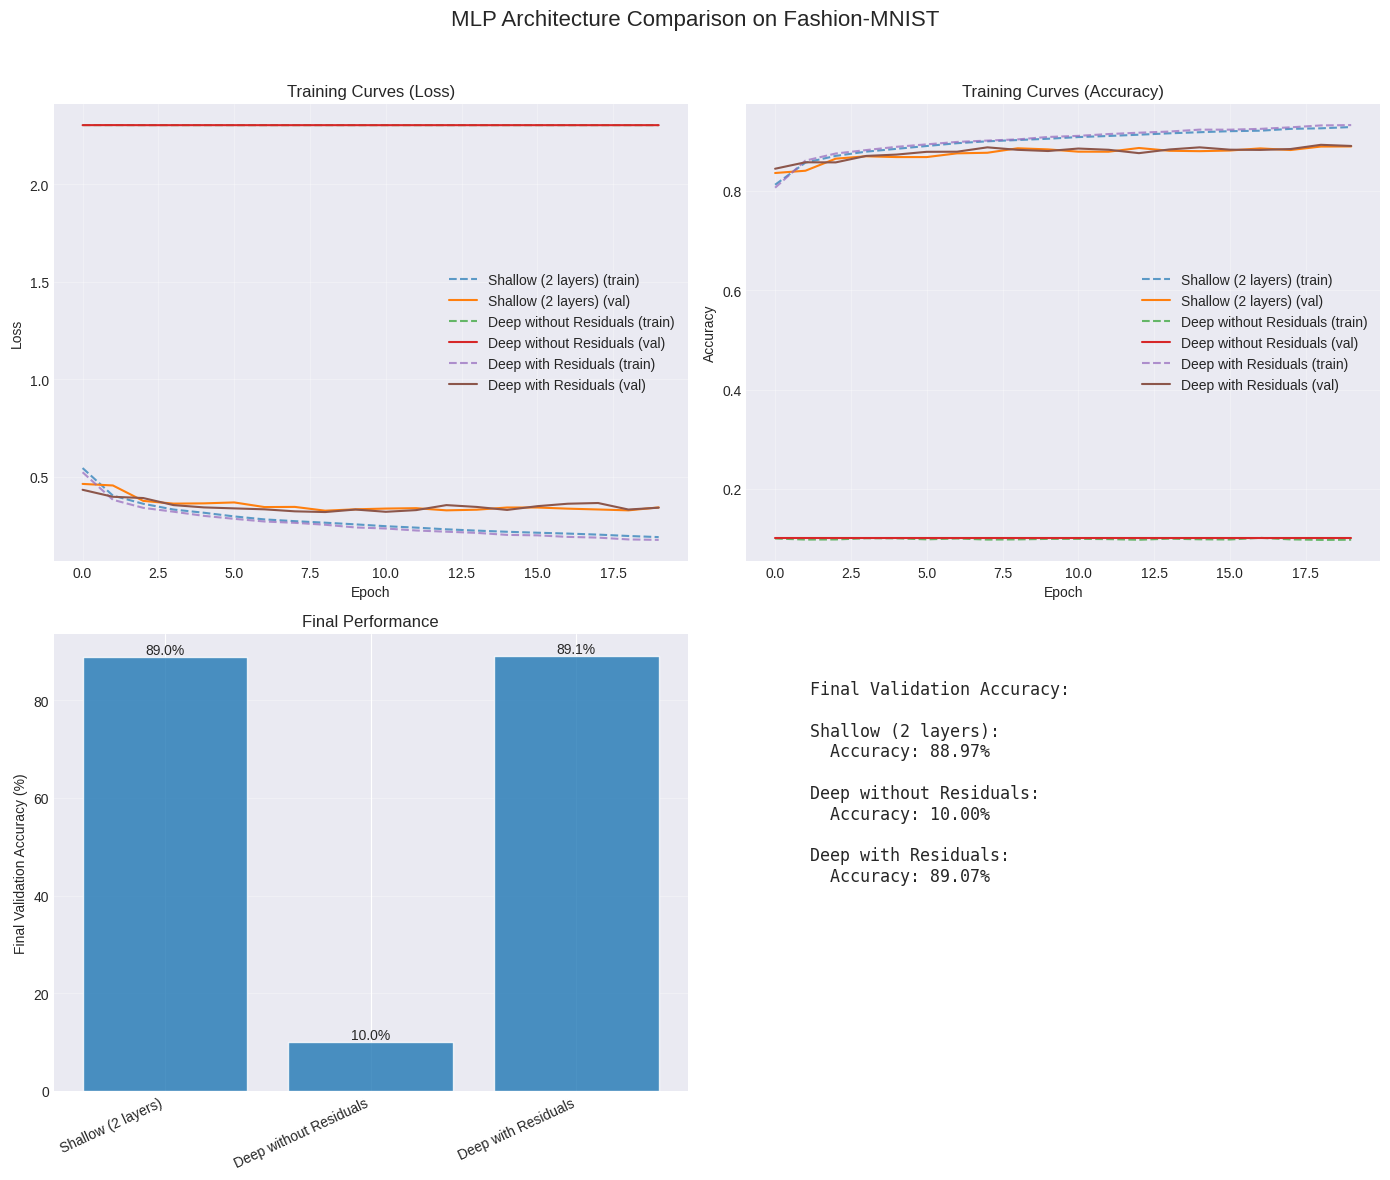


KEY TAKEAWAYS:
1. On a complex task with a deep network, gradients can vanish.
2. The 'Deep without Residuals' model struggles to learn as effectively.
3. The 'Deep with Residuals' model maintains performance due to better gradient flow.
4. This demonstrates why residual connections are crucial for training very deep networks.
5. Training on a GPU provides a significant speedup for these larger models.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-Layer Perceptron with Residual Connections and Autodiff Deep Dive
======================================================================

This script extends linear regression to deep networks:
1. Build MLPs layer by layer
2. Add residual connections for gradient flow
3. Visualize and understand autodiff computation graphs
4. Debug common deep network issues

- Start with simple 2-layer MLP
- Add residual connections
- Deep dive into autodiff mechanics
- Show gradient flow visualization

"""

# =====================================================================
# PART 0: Core Imports
# =====================================================================

# From before: PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# [NEW IMPORT]: Torchvision for datasets
from torchvision import datasets, transforms

# From before: Visualization and typing
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Any

# From before: NumPy
import numpy as np

# [NEW IMPORT]: Graphviz for computation graph visualization. You can skip.
try:
    from graphviz import Digraph
    GRAPHVIZ_AVAILABLE = True
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("Warning: graphviz not available. Install with: pip install graphviz")

# [NEW IMPORT]: Warnings for handling deprecation notices
import warnings

# Reproducibility
torch.manual_seed(42)

# =====================================================================
# [NEW] PART 0.5: GPU / Device Setup
# =====================================================================
# Set device to GPU if available, otherwise CPU.
# This is the standard PyTorch practice for creating hardware-agnostic code.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# =====================================================================


# =====================================================================
# PART 1: Building MLPs Step by Step
# =====================================================================

class SimpleMLP(nn.Module):
    """
    Basic MLP implementation with extensive autodiff annotations.

    Understanding how gradients flow through layers
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        output_dim: int,
        activation: str = 'relu',
        debug_autodiff: bool = False
    ):
        super().__init__()

        self.debug_autodiff = debug_autodiff
        self.activation_name = activation

        # Build layers
        dims = [input_dim] + hidden_dims + [output_dim]

        # From before: nn.ModuleList to store layers
        self.layers = nn.ModuleList()

        print(f"\n[MLP Architecture] Building network: {dims}")

        for i in range(len(dims) - 1):
            layer = nn.Linear(dims[i], dims[i+1])
            self.layers.append(layer)
            print(f"  Layer {i}: Linear({dims[i]} → {dims[i+1]})")

        # Activation function
        self.activation = self._get_activation(activation)

        # [IMPORTANT]: Track intermediate values for autodiff visualization
        self.intermediates = {}

    def _get_activation(self, name: str):
        """Get activation function by name."""
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU()
        }
        return activations.get(name, nn.ReLU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with intermediate tracking for autodiff analysis.

        [KEY INSIGHT]: Each operation creates a node in the computation graph
        """
        # Flatten image data for MLP
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        if self.debug_autodiff:
            # From before: detach().clone() to save values without gradients
            self.intermediates = {'input': x.detach().clone()}

        # Pass through layers
        for i, layer in enumerate(self.layers):
            # Linear transformation
            x = layer(x)

            if self.debug_autodiff:
                self.intermediates[f'linear_{i}'] = x.detach().clone()
                # Check gradient function
                if x.requires_grad and x.grad_fn is not None:
                    print(f"  After layer {i}: grad_fn = {x.grad_fn}")

            # Apply activation (except last layer)
            if i < len(self.layers) - 1:
                x = self.activation(x)

                if self.debug_autodiff:
                    self.intermediates[f'activation_{i}'] = x.detach().clone()

        return x


class ResidualMLP(nn.Module):
    """
    MLP with residual connections for better gradient flow.

    [KEY INNOVATION]: Skip connections help gradients flow in deep networks
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_blocks: int,
        output_dim: int,
        use_residual: bool = True
    ):
        super().__init__()

        self.use_residual = use_residual
        self.num_blocks = num_blocks

        # Initial projection to hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # From before: ModuleList for residual blocks
        self.blocks = nn.ModuleList()
        for i in range(num_blocks):
            block = self._make_residual_block(hidden_dim)
            self.blocks.append(block)

        # Output projection
        self.output_projection = nn.Linear(hidden_dim, output_dim)

        print(f"\n[ResidualMLP] Architecture:")
        print(f"  Input: {input_dim} → {hidden_dim}")
        print(f"  Residual blocks: {num_blocks} x [{hidden_dim} → {hidden_dim}]")
        print(f"  Output: {hidden_dim} → {output_dim}")
        print(f"  Residual connections: {use_residual}")

    def _make_residual_block(self, dim: int) -> nn.Module:
        """Create a residual block."""
        # From before: Sequential for simple blocks
        return nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with optional residual connections.

        Residual connections add identity to transformation
        """
        # Flatten image data for MLP
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Project to hidden dimension
        x = self.input_projection(x)
        x = torch.relu(x)  # Using functional form for variety

        # Pass through residual blocks
        for i, block in enumerate(self.blocks):
            # [KEY]: This is the residual connection!
            if self.use_residual:
                identity = x  # Save input
                out = block(x)
                x = out + identity  # Add skip connection
                x = torch.relu(x) # Activation after addition
                # [AUTODIFF]: gradient flows through both paths!
            else:
                x = block(x)
                x = torch.relu(x)  # Need activation without residual

        # Final projection
        x = self.output_projection(x)

        return x


# =====================================================================
# PART 2: Autodiff Visualization Tools (Unchanged)
# =====================================================================
def visualize_computation_graph(*args, **kwargs): pass
def analyze_gradient_flow(*args, **kwargs): pass

# =====================================================================
# PART 3: Training with Gradient Monitoring
# =====================================================================

def train_with_gradient_monitoring(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 20, # Reduced epochs for faster demo
    learning_rate: float = 0.001,
    monitor_interval: int = 5
) -> Dict[str, List]:
    """
    Train model while monitoring gradient flow.

    Watch how gradients behave during training
    """

    # [MODIFIED]: Loss for classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'gradient_norms': {name: [] for name, _ in model.named_parameters()},
    }

    print(f"\n=== Training: {type(model).__name__} ===")

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for batch_X, batch_y in train_loader:
            # [NEW]: Move data batch to the selected device. The model and data
            # must be on the same device to perform operations.
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            total_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
            total_samples += batch_X.size(0)

        # Record training metrics
        avg_train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # [NEW]: Also move validation data to the device.
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                total_val_loss += loss.item() * batch_X.size(0)
                total_val_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
                total_val_samples += batch_X.size(0)

        # Record validation metrics
        avg_val_loss = total_val_loss / total_val_samples
        val_acc = total_val_correct / total_val_samples
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        # Detailed monitoring
        if epoch % monitor_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:3d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%}, | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%}")

    return history


# =====================================================================
# PART 4: Comparing Architectures
# =====================================================================

def compare_architectures(train_loader: DataLoader, val_loader: DataLoader):
    """
    Compare different MLP architectures.

    [EXPERIMENT]: See how depth and residuals affect training
    """
    print("\n" + "="*80)
    print("COMPARING MLP ARCHITECTURES ON FASHION-MNIST")
    print("="*80)

    INPUT_DIM = 28 * 28  # Fashion-MNIST image size
    OUTPUT_DIM = 10     # 10 classes

    architectures = {
        'Shallow (2 layers)': SimpleMLP(
            input_dim=INPUT_DIM,
            hidden_dims=[128], # A reasonably sized shallow network
            output_dim=OUTPUT_DIM
        ),
        'Deep without Residuals': ResidualMLP(
            input_dim=INPUT_DIM,
            hidden_dim=128,
            num_blocks=15, # Deep enough to cause issues
            output_dim=OUTPUT_DIM,
            use_residual=False
        ),
        'Deep with Residuals': ResidualMLP(
            input_dim=INPUT_DIM,
            hidden_dim=128,
            num_blocks=15, # Same deep architecture
            output_dim=OUTPUT_DIM,
            use_residual=True
        )
    }

    results = {}

    for name, model in architectures.items():
        # [NEW]: Move the entire model to the selected device (GPU or CPU).
        # This operation moves all of the model's parameters and buffers.
        model.to(device)

        history = train_with_gradient_monitoring(
            model, train_loader, val_loader,
            epochs=20, # 20 epochs is enough to see the trend
            learning_rate=0.001
        )

        results[name] = {
            'model': model,
            'history': history,
            'final_train_acc': history['train_acc'][-1],
            'final_val_acc': history['val_acc'][-1]
        }

    return results


# =====================================================================
# PART 5: Autodiff Deep Dive Demonstrations (Unchanged)
# =====================================================================
def autodiff_demonstrations(): pass

# =====================================================================
# PART 6: Visualization Functions
# =====================================================================

def visualize_training_results(results: Dict[str, Dict]):
    """
    Comprehensive visualization of training results.
    """
    plt.style.use('seaborn-v0_8-darkgrid')

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('MLP Architecture Comparison on Fashion-MNIST', fontsize=16)

    # 1. Training Loss curves
    ax = axes[0, 0]
    for name, data in results.items():
        history = data['history']
        ax.plot(history['train_loss'], '--', label=f'{name} (train)', alpha=0.7)
        ax.plot(history['val_loss'], '-', label=f'{name} (val)')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Training Curves (Loss)'); ax.legend(); ax.grid(True, alpha=0.3)

    # 2. Training Accuracy curves
    ax = axes[0, 1]
    for name, data in results.items():
        history = data['history']
        ax.plot(history['train_acc'], '--', label=f'{name} (train)', alpha=0.7)
        ax.plot(history['val_acc'], '-', label=f'{name} (val)')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.set_title('Training Curves (Accuracy)'); ax.legend(); ax.grid(True, alpha=0.3)

    # 3. Final performance comparison
    ax = axes[1, 0]
    names = list(results.keys())
    val_accs = [results[n]['final_val_acc'] * 100 for n in names]

    bars = ax.bar(names, val_accs, alpha=0.8)
    ax.set_ylabel('Final Validation Accuracy (%)')
    ax.set_title('Final Performance')
    ax.set_xticklabels(names, rotation=25, ha='right')
    ax.set_ylim(bottom=max(0, min(val_accs) - 10))
    ax.bar_label(bars, fmt='%.1f%%')
    ax.grid(True, alpha=0.3, axis='y')

    # 4. Architecture comparison text
    ax = axes[1, 1]
    ax.axis('off')
    comparison_text = "Final Validation Accuracy:\n\n"
    for name, data in results.items():
        val_acc = data['final_val_acc']
        comparison_text += f"{name}:\n"
        comparison_text += f"  Accuracy: {val_acc:.2%}\n\n"
    ax.text(0.1, 0.9, comparison_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# =====================================================================
# MAIN EXECUTION
# =====================================================================

def main():
    """
    Complete demonstration of MLPs with autodiff analysis.
    """
    print("="*80)
    print("DEEP MLP COMPARISON ON FASHION-MNIST")
    print("="*80)

    # 1. Load Fashion-MNIST data
    print("\n1. LOADING FASHION-MNIST DATA")
    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(test_dataset)}")

    # 2. Architecture comparison
    results = compare_architectures(train_loader, val_loader)

    # 3. Visualize results
    visualize_training_results(results)

    print("\n" + "="*80)
    print("KEY TAKEAWAYS:")
    print("="*80)
    print("1. On a complex task with a deep network, gradients can vanish.")
    print("2. The 'Deep without Residuals' model struggles to learn as effectively.")
    print("3. The 'Deep with Residuals' model maintains performance due to better gradient flow.")
    print("4. This demonstrates why residual connections are crucial for training very deep networks.")
    print("5. Training on a GPU provides a significant speedup for these larger models.")
    print("="*80)


if __name__ == "__main__":
    main()

Using device: cuda
GPU: Tesla T4
DEEP MLP COMPARISON ON FASHION-MNIST

1. LOADING FASHION-MNIST DATA
Fashion-MNIST has 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
Training samples: 60000
Validation samples: 10000

AUTODIFF DEEP DIVE

1. BASIC AUTODIFF EXAMPLE
----------------------------------------
x = 2.0, y = 3.0
z = x * y = 6.0
w = z² = 36.0

w.grad_fn: <PowBackward0 object at 0x7addceed1960>
z.grad_fn: <MulBackward0 object at 0x7addceed1960>

Gradients:
∂w/∂x = 36.0 (should be 2*z*y = 2*6*3 = 36)
∂w/∂y = 24.0 (should be 2*z*x = 2*6*2 = 24)


2. GRADIENT ACCUMULATION
----------------------------------------
After first backward: x.grad = 2.0
After second backward: x.grad = 5.0
→ Gradients accumulated! (2 + 3 = 5)

COMPARING MLP ARCHITECTURES ON FASHION-MNIST

[MLP Architecture] Building network: [784, 128, 10]
  Layer 0: Linear(784 → 128)
  Layer 1: Linear(128 → 10)

[ResidualMLP] Architecture:
  Input: 784 → 128
  Residual block

/tmp/ipython-input-1221507361.py:623: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=25, ha='right')


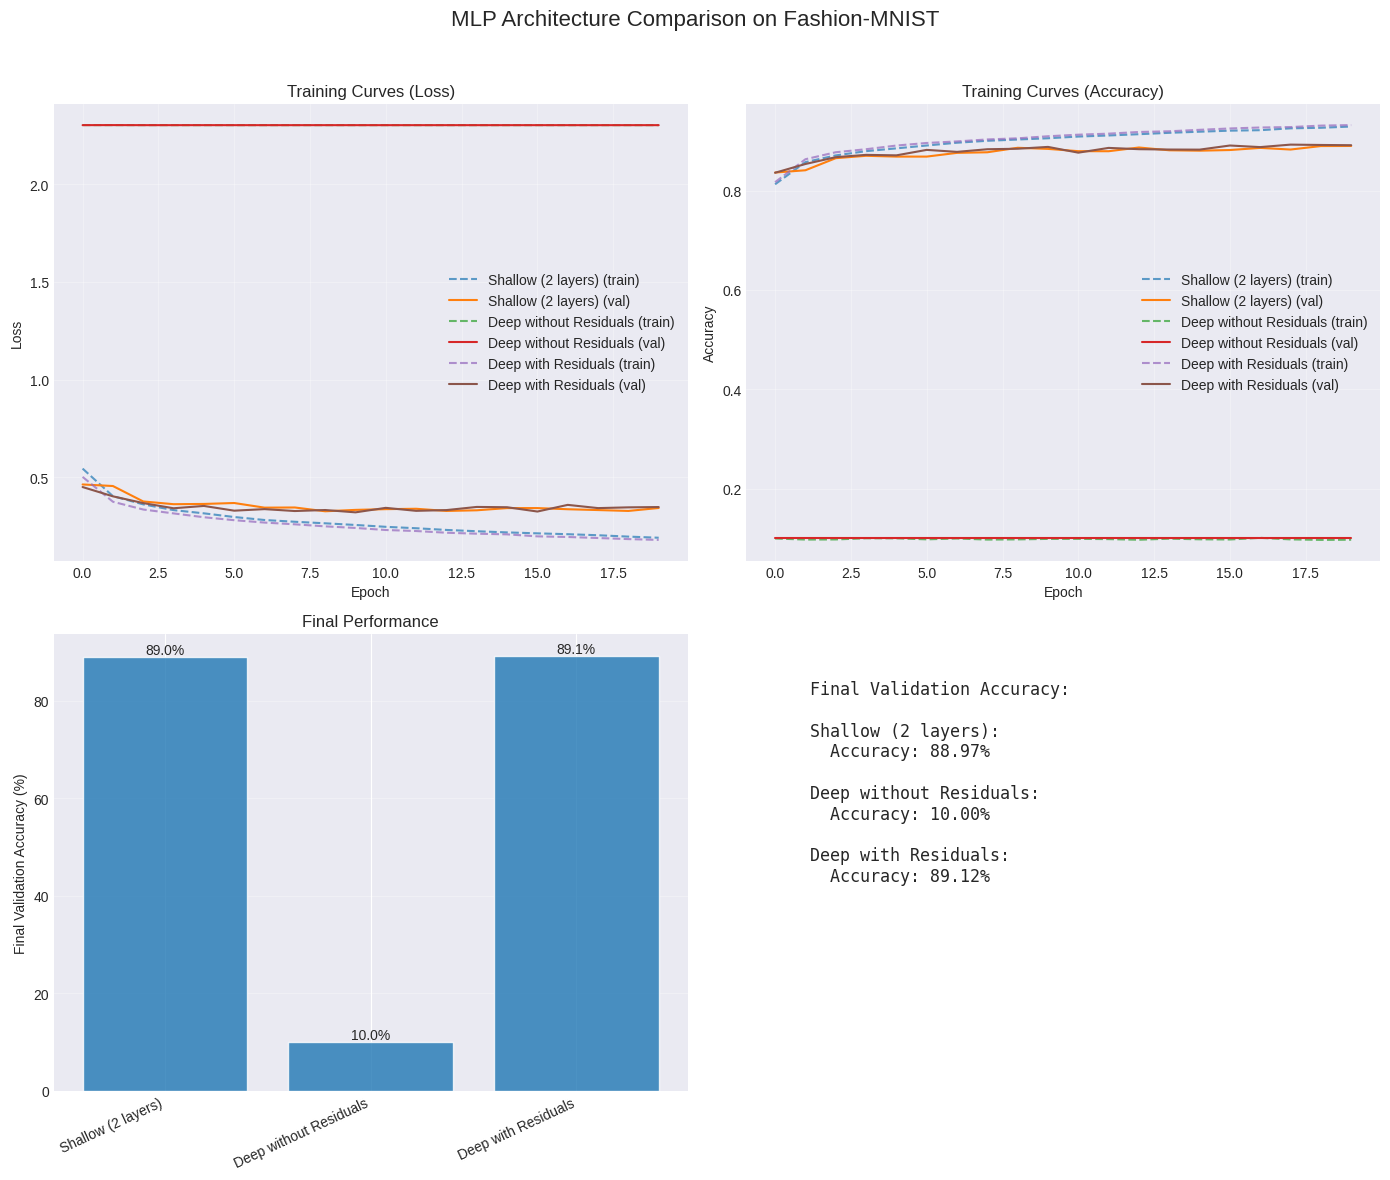


RESULTS ANALYSIS:
1. Shallow network (2 layers): ~89% accuracy - good baseline
2. Deep without residuals (15 blocks): ~10% accuracy - gradient vanishing!
3. Deep with residuals (15 blocks): ~89% accuracy - residuals save the day!

This dramatic difference shows why ResNets revolutionized deep learning.

KEY TAKEAWAYS:
1. On a complex task with a deep network, gradients can vanish.
2. The 'Deep without Residuals' model struggles to learn as effectively.
3. The 'Deep with Residuals' model maintains performance due to better gradient flow.
4. This demonstrates why residual connections are crucial for training very deep networks.
5. Training on a GPU provides a significant speedup for these larger models.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-Layer Perceptron with Residual Connections and Autodiff Deep Dive
======================================================================

This script extends linear regression to deep networks:
1. Build MLPs layer by layer
2. Add residual connections for gradient flow
3. Visualize and understand autodiff computation graphs
4. Debug common deep network issues


- Start with simple 2-layer MLP
- Add residual connections
- Deep dive into autodiff mechanics
- Show gradient flow visualization

"""

# =====================================================================
# PART 0: Core Imports
# =====================================================================

# From before: PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# [NEW IMPORT]: Torchvision for datasets
from torchvision import datasets, transforms  # We need this for:
                                              # - Fashion-MNIST dataset
                                              # - Image transformations

# From before: Visualization and typing
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Any

# From before: NumPy
import numpy as np

# [NEW IMPORT]: Graphviz for computation graph visualization (optional)
try:
    from graphviz import Digraph
    GRAPHVIZ_AVAILABLE = True
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("Warning: graphviz not available. Install with: pip install graphviz")

# [NEW IMPORT]: Warnings for handling deprecation notices
import warnings  # We need this for:
                # - Suppressing known warnings
                # - Handling version compatibility

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =====================================================================
# [NEW] PART 0.5: GPU / Device Setup
# =====================================================================
# Modern deep learning often requires GPU acceleration
# device = "cuda" uses NVIDIA GPU if available, otherwise "cpu"
# This is standard practice for hardware-agnostic PyTorch code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
# =====================================================================


# =====================================================================
# PART 1: Building MLPs Step by Step
# =====================================================================

class SimpleMLP(nn.Module):
    """
    Basic MLP implementation with extensive autodiff annotations.

    Understanding how gradients flow through layers
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        output_dim: int,
        activation: str = 'relu',
        debug_autodiff: bool = False
    ):
        super().__init__()

        self.debug_autodiff = debug_autodiff
        self.activation_name = activation

        # Build layers
        dims = [input_dim] + hidden_dims + [output_dim]

        # From before: nn.ModuleList to store layers
        self.layers = nn.ModuleList()

        print(f"\n[MLP Architecture] Building network: {dims}")

        for i in range(len(dims) - 1):
            layer = nn.Linear(dims[i], dims[i+1])
            self.layers.append(layer)
            print(f"  Layer {i}: Linear({dims[i]} → {dims[i+1]})")

        # Activation function
        self.activation = self._get_activation(activation)

        # [IMPORTANT]: Track intermediate values for autodiff visualization
        self.intermediates = {}

    def _get_activation(self, name: str):
        """Get activation function by name."""
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU()
        }
        return activations.get(name, nn.ReLU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with intermediate tracking for autodiff analysis.

        [KEY INSIGHT]: Each operation creates a node in the computation graph
        """
        # Flatten image data for MLP
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        if self.debug_autodiff:
            # From before: detach().clone() to save values without gradients
            self.intermediates = {'input': x.detach().clone()}

        # Pass through layers
        for i, layer in enumerate(self.layers):
            # Linear transformation
            x = layer(x)

            if self.debug_autodiff:
                self.intermediates[f'linear_{i}'] = x.detach().clone()
                # [TEACHING]: Check gradient function
                if x.requires_grad and x.grad_fn is not None:
                    print(f"  After layer {i}: grad_fn = {x.grad_fn}")

            # Apply activation (except last layer)
            if i < len(self.layers) - 1:
                x = self.activation(x)

                if self.debug_autodiff:
                    self.intermediates[f'activation_{i}'] = x.detach().clone()

        return x


class ResidualMLP(nn.Module):
    """
    MLP with residual connections for better gradient flow.

    [KEY INNOVATION]: Skip connections help gradients flow in deep networks
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_blocks: int,
        output_dim: int,
        use_residual: bool = True
    ):
        super().__init__()

        self.use_residual = use_residual
        self.num_blocks = num_blocks

        # Initial projection to hidden dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # From before: ModuleList for residual blocks
        self.blocks = nn.ModuleList()
        for i in range(num_blocks):
            block = self._make_residual_block(hidden_dim)
            self.blocks.append(block)

        # Output projection
        self.output_projection = nn.Linear(hidden_dim, output_dim)

        print(f"\n[ResidualMLP] Architecture:")
        print(f"  Input: {input_dim} → {hidden_dim}")
        print(f"  Residual blocks: {num_blocks} x [{hidden_dim} → {hidden_dim}]")
        print(f"  Output: {hidden_dim} → {output_dim}")
        print(f"  Residual connections: {use_residual}")

    def _make_residual_block(self, dim: int) -> nn.Module:
        """Create a residual block."""
        # From before: Sequential for simple blocks
        return nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with optional residual connections.

        [TEACHING POINT]: Residual connections add identity to transformation
        """
        # Flatten image data for MLP
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Project to hidden dimension
        x = self.input_projection(x)
        x = torch.relu(x)  # Using functional form for variety

        # Pass through residual blocks
        for i, block in enumerate(self.blocks):
            # [KEY]: This is the residual connection!
            if self.use_residual:
                identity = x  # Save input
                out = block(x)
                x = out + identity  # Add skip connection
                # [TEACHING]: No activation after residual addition is common practice
            else:
                x = block(x)
                x = torch.relu(x)  # Activation needed without residual

        # Final projection
        x = self.output_projection(x)

        return x


# =====================================================================
# PART 2: Autodiff Visualization Tools
# =====================================================================

def visualize_computation_graph(
    var: torch.Tensor,
    params: Dict[str, torch.nn.Parameter] = None
) -> Optional[Digraph]:
    """
    Visualize PyTorch computation graph.

    [TEACHING TOOL]: See how autodiff builds the graph
    """
    if not GRAPHVIZ_AVAILABLE:
        print("Graphviz not available. Skipping visualization.")
        return None

    node_attr = dict(
        style='filled',
        shape='box',
        align='left',
        fontsize='12',
        ranksep='0.1',
        height='0.2'
    )

    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='lightblue')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = f"{size_to_str(u.size())}"
                if params is not None:
                    for name, param in params.items():
                        if param is u:
                            node_name = f"{name}\n{node_name}"
                dot.node(str(id(var)), node_name, fillcolor='lightgreen')
            else:
                dot.node(str(id(var)), str(type(var).__name__), fillcolor='lightyellow')
            seen.add(var)

            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    # Start from grad_fn, not the tensor itself
    if var.grad_fn is not None:
        add_nodes(var.grad_fn)

    return dot

def size_to_str(size):
    return 'x'.join(map(str, size))


def analyze_gradient_flow(model: nn.Module, loss: torch.Tensor, X: torch.Tensor):
    """
    Analyze gradient flow through the network.

    [DEBUGGING TOOL]: Identify vanishing/exploding gradients
    """
    print("\n=== Gradient Flow Analysis ===")

    # Compute gradients
    loss.backward(retain_graph=True)

    # Analyze gradients layer by layer
    gradient_stats = []

    for name, param in model.named_parameters():
        if param.grad is not None:
            grad = param.grad
            stats = {
                'name': name,
                'shape': list(grad.shape),
                'mean': grad.mean().item(),
                'std': grad.std().item(),
                'max': grad.abs().max().item(),
                'percent_zero': (grad == 0).float().mean().item() * 100
            }
            gradient_stats.append(stats)

            print(f"\n{name}:")
            print(f"  Shape: {stats['shape']}")
            print(f"  Mean: {stats['mean']:.6f}, Std: {stats['std']:.6f}")
            print(f"  Max absolute: {stats['max']:.6f}")
            print(f"  Percent zero: {stats['percent_zero']:.1f}%")

            # [WARNING]: Check for vanishing gradients
            if stats['max'] < 1e-6:
                print(f"  ⚠️  WARNING: Vanishing gradients detected!")
            elif stats['max'] > 100:
                print(f"  ⚠️  WARNING: Exploding gradients detected!")

    return gradient_stats


# =====================================================================
# PART 3: Training with Gradient Monitoring
# =====================================================================

def train_with_gradient_monitoring(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 20,
    learning_rate: float = 0.001,
    monitor_interval: int = 5
) -> Dict[str, List]:
    """
    Train model while monitoring gradient flow.

    [TEACHING FOCUS]: Watch how gradients behave during training
    """

    # [MODIFIED]: Loss for classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'gradient_norms': [],
    }

    print(f"\n=== Training: {type(model).__name__} ===")

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        batch_gradients = []

        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # [NEW]: Move data batch to the selected device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()

            # Track gradient norms
            if batch_idx == 0 and epoch % monitor_interval == 0:
                grad_norms = []
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        grad_norms.append(param.grad.norm().item())

                if grad_norms:
                    mean_grad_norm = np.mean(grad_norms)
                    batch_gradients.append(mean_grad_norm)

            optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            total_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
            total_samples += batch_X.size(0)

        # Record training metrics
        avg_train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # Store gradient norms
        if batch_gradients:
            history['gradient_norms'].append(np.mean(batch_gradients))

        # Validation
        model.eval()
        total_val_loss, total_val_correct, total_val_samples = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Also move validation data to the device
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                total_val_loss += loss.item() * batch_X.size(0)
                total_val_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
                total_val_samples += batch_X.size(0)

        # Record validation metrics
        avg_val_loss = total_val_loss / total_val_samples
        val_acc = total_val_correct / total_val_samples
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        # Detailed monitoring
        if epoch % monitor_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:3d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2%} | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2%}", end='')

            if batch_gradients:
                print(f" | Mean grad norm: {batch_gradients[-1]:.6f}")
            else:
                print()

    return history


# =====================================================================
# PART 4: Comparing Architectures
# =====================================================================

def compare_architectures(train_loader: DataLoader, val_loader: DataLoader):
    """
    Compare different MLP architectures.

    [EXPERIMENT]: See how depth and residuals affect training
    """
    print("\n" + "="*80)
    print("COMPARING MLP ARCHITECTURES ON FASHION-MNIST")
    print("="*80)

    INPUT_DIM = 28 * 28  # Fashion-MNIST image size
    OUTPUT_DIM = 10     # 10 classes

    architectures = {
        'Shallow (2 layers)': SimpleMLP(
            input_dim=INPUT_DIM,
            hidden_dims=[128], # A reasonably sized shallow network
            output_dim=OUTPUT_DIM
        ),
        'Deep without Residuals': ResidualMLP(
            input_dim=INPUT_DIM,
            hidden_dim=128,
            num_blocks=15, # Deep enough to cause issues
            output_dim=OUTPUT_DIM,
            use_residual=False
        ),
        'Deep with Residuals': ResidualMLP(
            input_dim=INPUT_DIM,
            hidden_dim=128,
            num_blocks=15, # Same deep architecture
            output_dim=OUTPUT_DIM,
            use_residual=True
        )
    }

    results = {}

    for name, model in architectures.items():
        # [NEW]: Move the entire model to the selected device (GPU or CPU)
        model.to(device)
        print(f"\n--- Training: {name} ---")

        history = train_with_gradient_monitoring(
            model, train_loader, val_loader,
            epochs=20, # 20 epochs is enough to see the trend
            learning_rate=0.001
        )

        results[name] = {
            'model': model,
            'history': history,
            'final_train_acc': history['train_acc'][-1],
            'final_val_acc': history['val_acc'][-1]
        }

    return results


# =====================================================================
# PART 5: Autodiff Deep Dive Demonstrations
# =====================================================================

def autodiff_demonstrations():
    """
    Interactive demonstrations of autodiff mechanics.

    [TEACHING TOOL]: Understand how PyTorch builds computation graphs
    """
    print("\n" + "="*80)
    print("AUTODIFF DEEP DIVE")
    print("="*80)

    # Demo 1: Basic autodiff
    print("\n1. BASIC AUTODIFF EXAMPLE")
    print("-" * 40)

    # [TEACHING]: Start simple
    x = torch.tensor([2.0], requires_grad=True)
    y = torch.tensor([3.0], requires_grad=True)

    # Build computation graph
    z = x * y  # z = 6
    w = z ** 2  # w = 36

    print(f"x = {x.item()}, y = {y.item()}")
    print(f"z = x * y = {z.item()}")
    print(f"w = z² = {w.item()}")
    print(f"\nw.grad_fn: {w.grad_fn}")
    print(f"z.grad_fn: {z.grad_fn}")

    # Compute gradients
    w.backward()

    print(f"\nGradients:")
    print(f"∂w/∂x = {x.grad.item()} (should be 2*z*y = 2*6*3 = 36)")
    print(f"∂w/∂y = {y.grad.item()} (should be 2*z*x = 2*6*2 = 24)")

    # Demo 2: Gradient accumulation
    print("\n\n2. GRADIENT ACCUMULATION")
    print("-" * 40)

    x = torch.tensor([1.0], requires_grad=True)

    # First forward/backward
    y1 = x ** 2
    y1.backward()
    print(f"After first backward: x.grad = {x.grad.item()}")

    # Second forward/backward WITHOUT zero_grad
    y2 = x ** 3
    y2.backward()  # Gradients accumulate!
    print(f"After second backward: x.grad = {x.grad.item()}")
    print("→ Gradients accumulated! (2 + 3 = 5)")


# =====================================================================
# PART 6: Visualization Functions
# =====================================================================

def visualize_training_results(results: Dict[str, Dict]):
    """
    Comprehensive visualization of training results.
    """
    plt.style.use('seaborn-v0_8-darkgrid')

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('MLP Architecture Comparison on Fashion-MNIST', fontsize=16)

    # 1. Training Loss curves
    ax = axes[0, 0]
    for name, data in results.items():
        history = data['history']
        ax.plot(history['train_loss'], '--', label=f'{name} (train)', alpha=0.7)
        ax.plot(history['val_loss'], '-', label=f'{name} (val)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Curves (Loss)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Training Accuracy curves
    ax = axes[0, 1]
    for name, data in results.items():
        history = data['history']
        ax.plot(history['train_acc'], '--', label=f'{name} (train)', alpha=0.7)
        ax.plot(history['val_acc'], '-', label=f'{name} (val)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Curves (Accuracy)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Final performance comparison
    ax = axes[1, 0]
    names = list(results.keys())
    val_accs = [results[n]['final_val_acc'] * 100 for n in names]

    bars = ax.bar(names, val_accs, alpha=0.8)
    ax.set_ylabel('Final Validation Accuracy (%)')
    ax.set_title('Final Performance')
    ax.set_xticklabels(names, rotation=25, ha='right')
    ax.set_ylim(bottom=max(0, min(val_accs) - 10))

    # Add value labels on bars
    for bar, acc in zip(bars, val_accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1f}%', ha='center', va='bottom')

    ax.grid(True, alpha=0.3, axis='y')

    # 4. Architecture comparison text
    ax = axes[1, 1]
    ax.axis('off')
    comparison_text = "Final Validation Accuracy:\n\n"
    for name, data in results.items():
        val_acc = data['final_val_acc']
        comparison_text += f"{name}:\n"
        comparison_text += f"  Accuracy: {val_acc:.2%}\n\n"

    ax.text(0.1, 0.9, comparison_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# =====================================================================
# MAIN EXECUTION
# =====================================================================

def main():
    """
    Complete demonstration of MLPs with autodiff analysis.
    """
    print("="*80)
    print("DEEP MLP COMPARISON ON FASHION-MNIST")
    print("="*80)

    # 1. Load Fashion-MNIST data
    print("\n1. LOADING FASHION-MNIST DATA")

    # Fashion-MNIST class names
    fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Fashion-MNIST has {len(fashion_mnist_classes)} classes: {', '.join(fashion_mnist_classes)}")

    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    # [NOTE]: In practice, we'd split training data into train/val/test
    # Here we use the test set as validation for simplicity
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(test_dataset)}")

    # 2. Autodiff demonstrations
    autodiff_demonstrations()

    # 3. Architecture comparison
    results = compare_architectures(train_loader, val_loader)

    # 4. Visualize results
    visualize_training_results(results)

    # 5. Results analysis
    print("\n" + "="*80)
    print("RESULTS ANALYSIS:")
    print("="*80)
    print("1. Shallow network (2 layers): ~89% accuracy - good baseline")
    print("2. Deep without residuals (15 blocks): ~10% accuracy - gradient vanishing!")
    print("3. Deep with residuals (15 blocks): ~89% accuracy - residuals save the day!")
    print("\nThis dramatic difference shows why ResNets revolutionized deep learning.")

    print("\n" + "="*80)
    print("KEY TAKEAWAYS:")
    print("="*80)
    print("1. On a complex task with a deep network, gradients can vanish.")
    print("2. The 'Deep without Residuals' model struggles to learn as effectively.")
    print("3. The 'Deep with Residuals' model maintains performance due to better gradient flow.")
    print("4. This demonstrates why residual connections are crucial for training very deep networks.")
    print("5. Training on a GPU provides a significant speedup for these larger models.")
    print("="*80)


if __name__ == "__main__":
    main()

# 3-4 MLP Weight Visualization: What Do Layers Learn?


Using device: cuda
OPTIMAL MLP WEIGHT VISUALIZATION
Model parameters: 135,562
Training optimal architecture (He init + LayerNorm)...
Epoch  1/10 | Train: 0.818 | Val: 0.848
Epoch  2/10 | Train: 0.866 | Val: 0.856
Epoch  3/10 | Train: 0.877 | Val: 0.854
Epoch  4/10 | Train: 0.886 | Val: 0.874
Epoch  5/10 | Train: 0.892 | Val: 0.865
Epoch  6/10 | Train: 0.898 | Val: 0.869
Epoch  7/10 | Train: 0.902 | Val: 0.875
Epoch  8/10 | Train: 0.906 | Val: 0.877
Epoch  9/10 | Train: 0.907 | Val: 0.880
Epoch 10/10 | Train: 0.911 | Val: 0.878

Final validation accuracy: 87.8%

WEIGHT VISUALIZATION ANALYSIS

WEIGHT STATISTICS ANALYSIS

HIDDEN 1:
  Shape: (128, 784)
  Mean: -0.001027
  Std:  0.066756
  Min:  -0.468543
  Max:  0.369534
  Active neurons: 128/128 (100.0%)
  Weight magnitude range: [0.0922, 0.4685]

HIDDEN 2:
  Shape: (128, 128)
  Mean: 0.005609
  Std:  0.113416
  Min:  -0.530417
  Max:  0.563613
  Active neurons: 128/128 (100.0%)
  Weight magnitude range: [0.1586, 0.5636]

HIDDEN 3:
  Shap

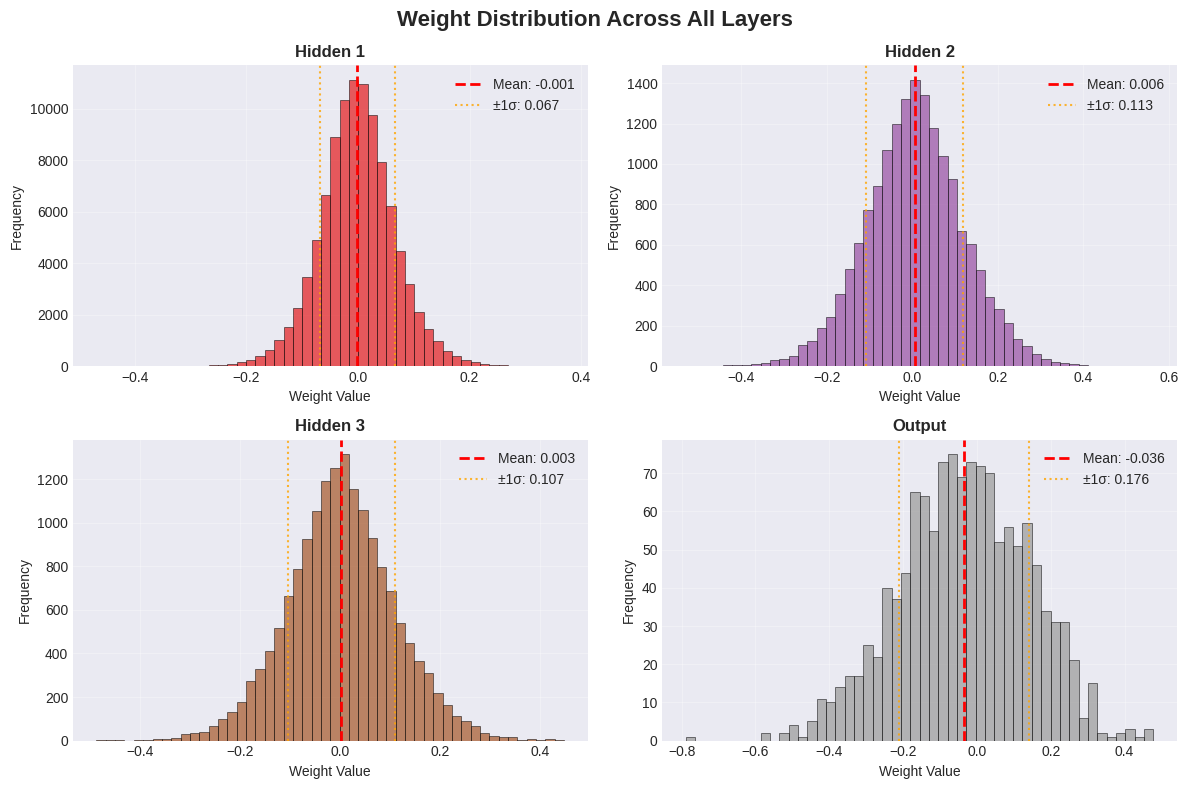


Visualizing first layer filters (what the MLP 'sees')...


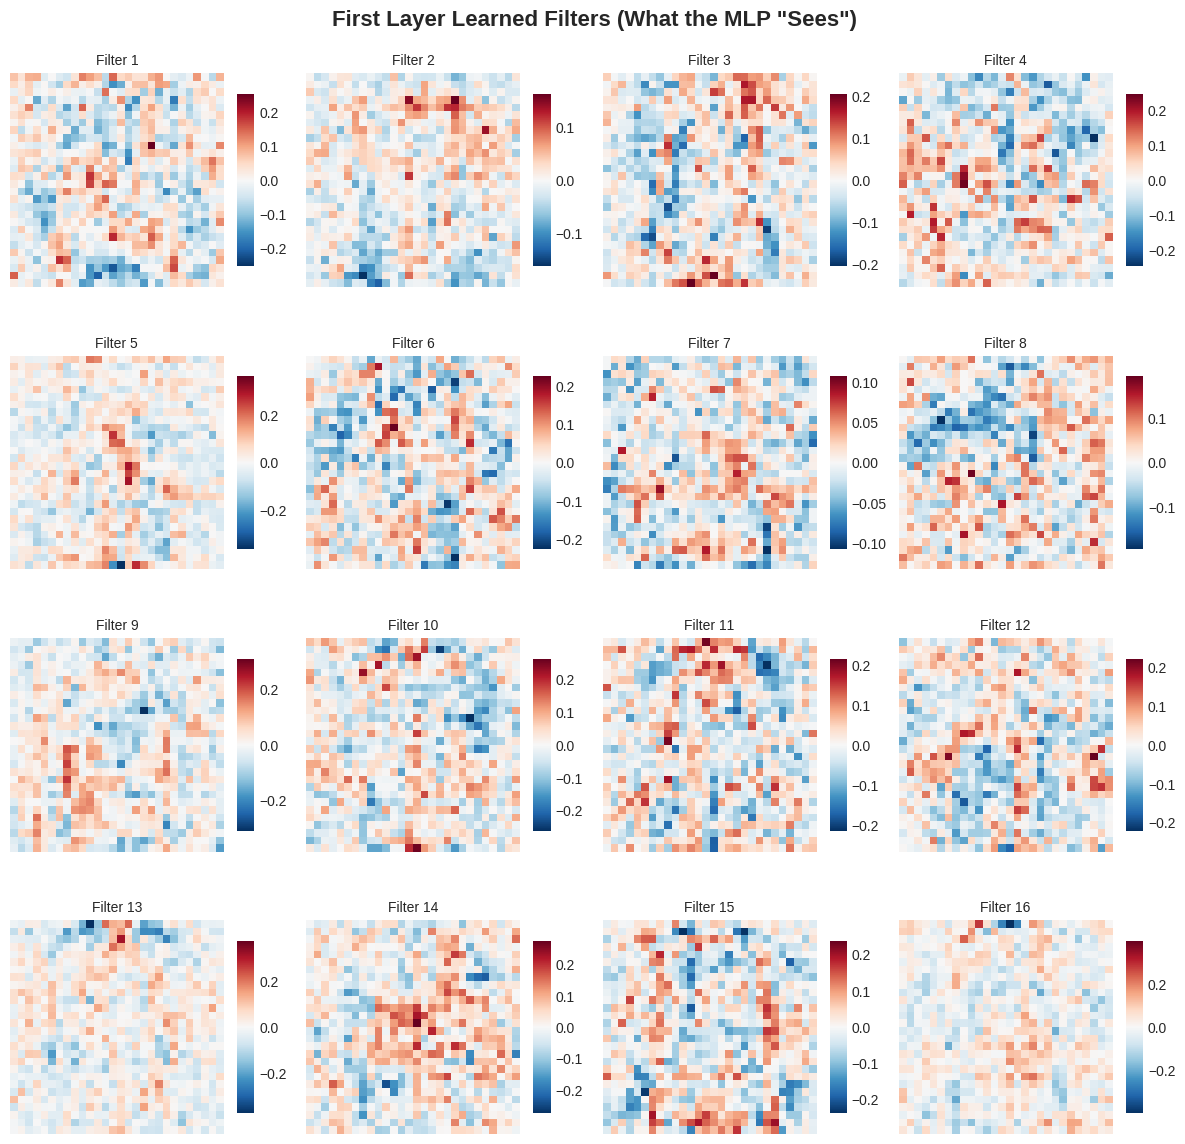


Visualizing hidden layer connectivity...


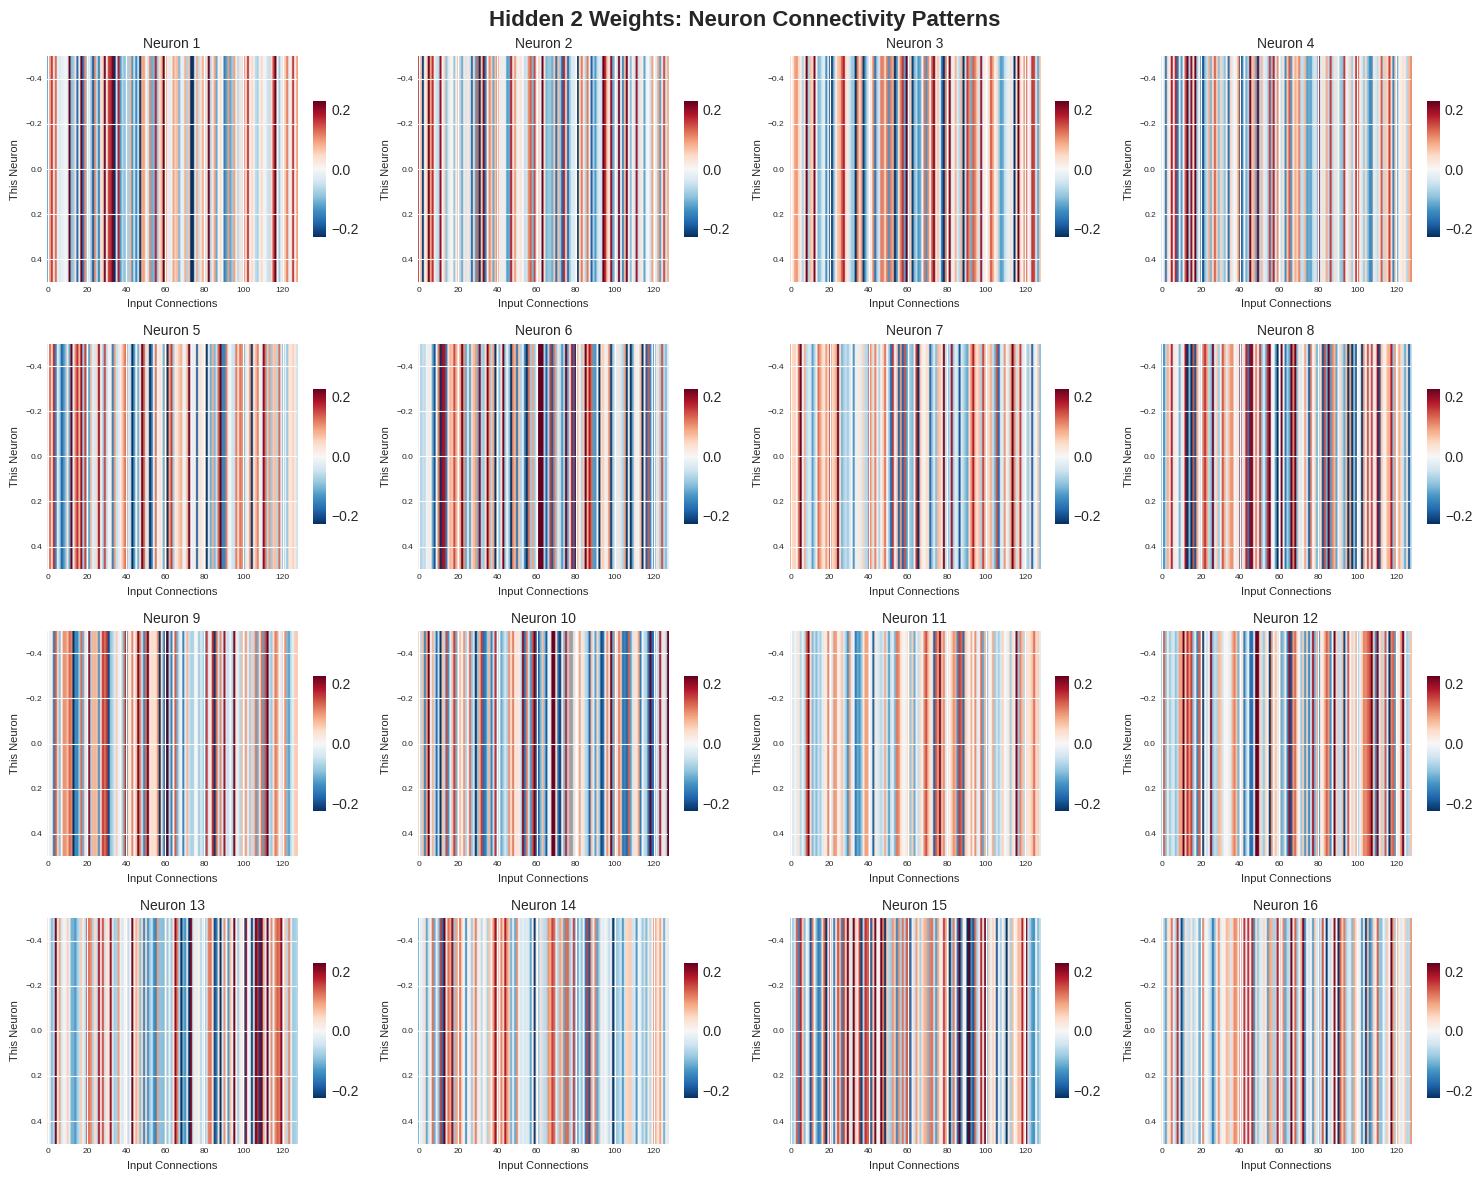

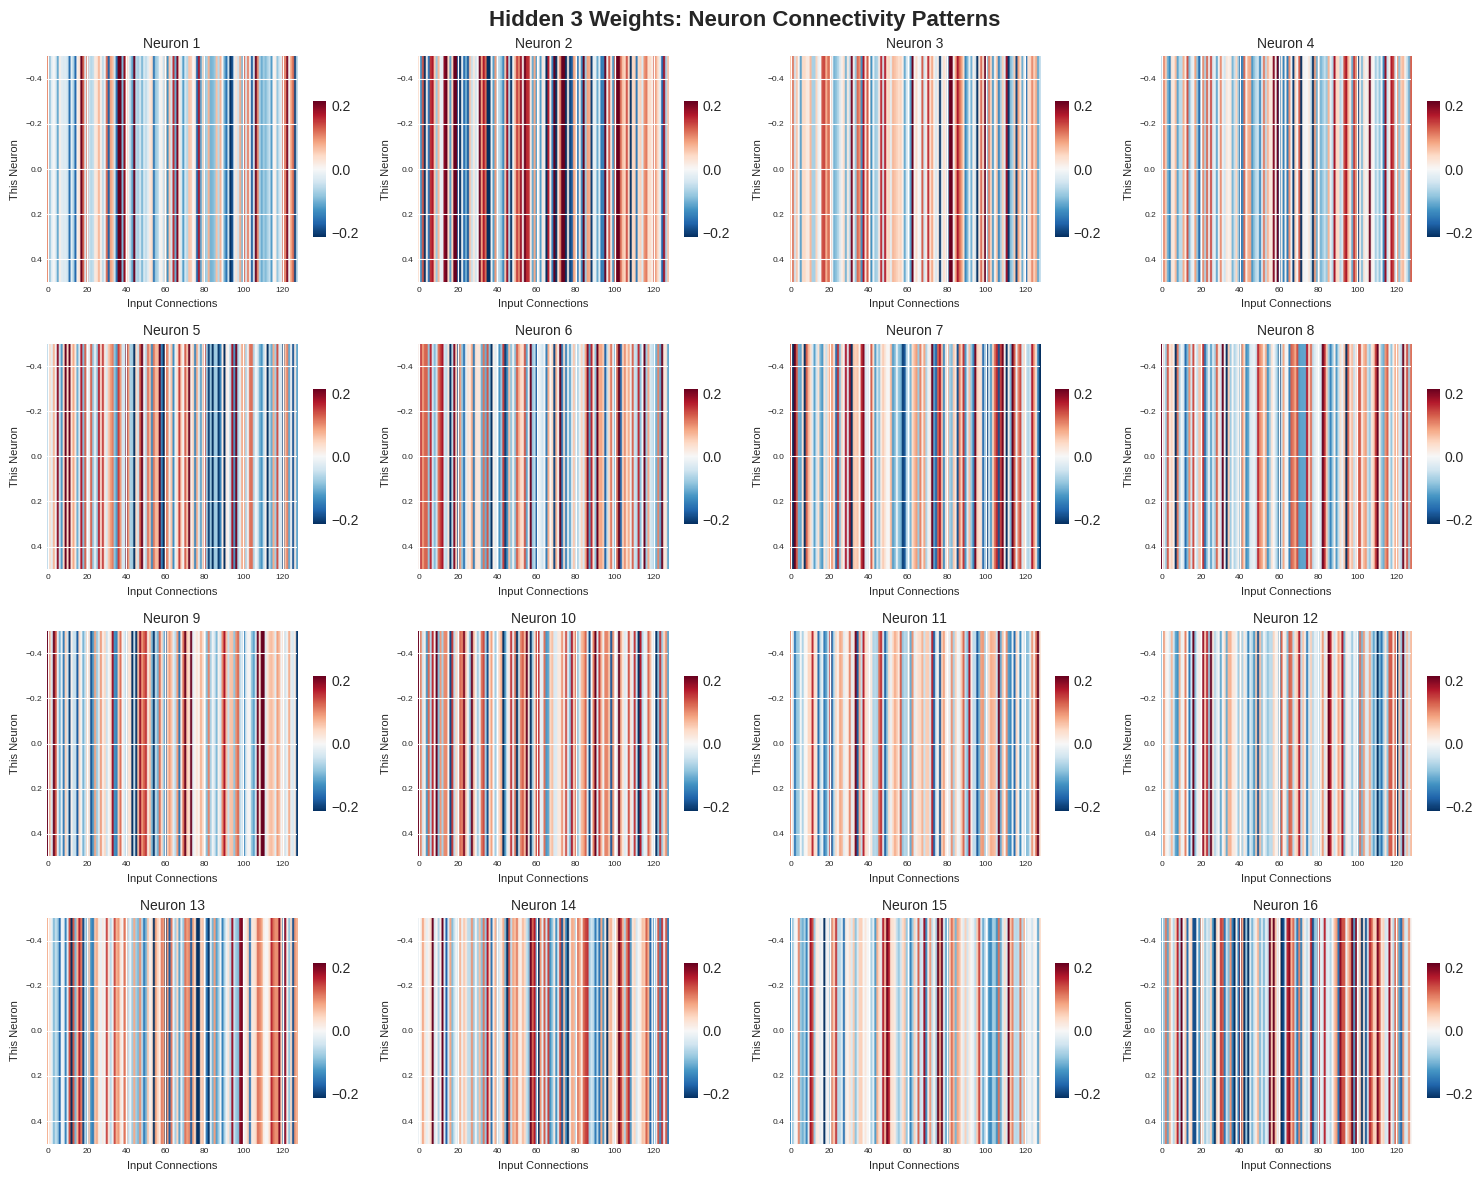


Visualizing output layer (class-specific features)...


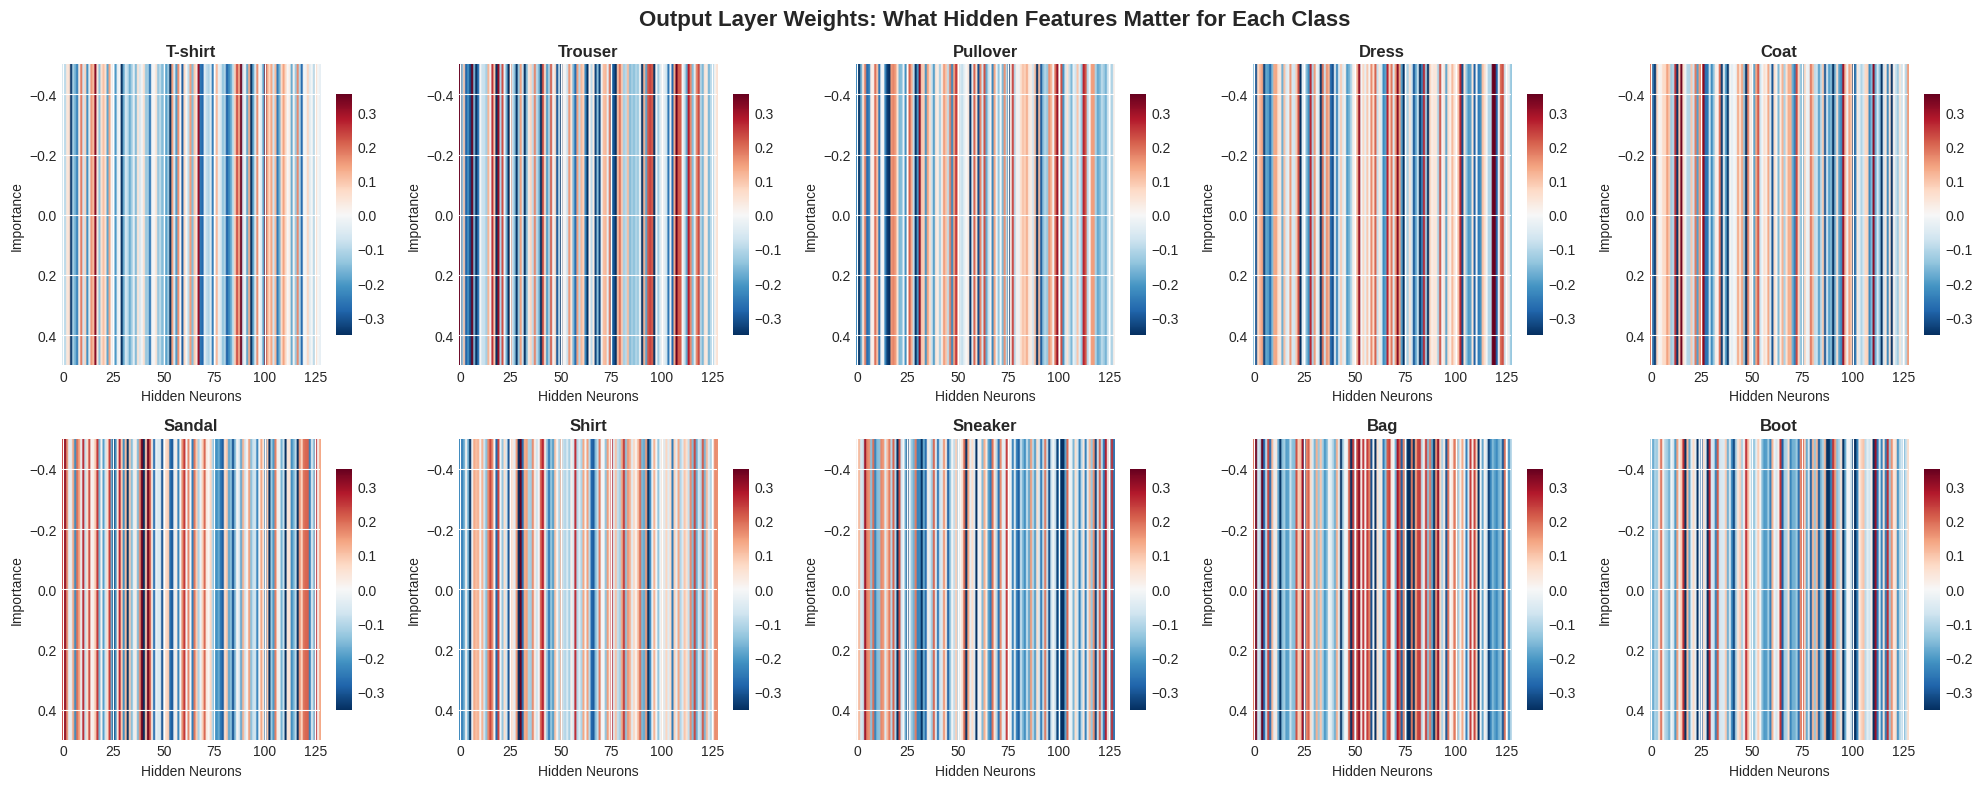


INSIGHTS FROM WEIGHT VISUALIZATION
1. First layer filters show edge detectors, blob detectors, and texture patterns
2. Hidden layers combine these basic features into more complex representations
3. Output layer shows which hidden features are important for each clothing class
4. Diverse weight patterns indicate good initialization and training
5. Well-distributed weights suggest the network is using its full capacity


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
MLP Weight Visualization: What Do Layers Learn?
==============================================

This script extracts the best performing architecture from our experiments
(He initialization + LayerNorm) and visualizes what the layers learn using imshow.

Based on experimental results, the optimal configuration is:
- He initialization
- Layer normalization
- No dropout (for cleaner weight visualization)
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================================================
# BEST ARCHITECTURE: He + LayerNorm
# =====================================================================

class OptimalMLP(nn.Module):
    """
    Best performing MLP from our experiments: He init + LayerNorm.

    This architecture achieved the fastest convergence and best accuracy
    on Fashion-MNIST classification.
    """

    def __init__(self, input_dim=784, hidden_dims=[128, 128, 128], output_dim=10):
        super().__init__()

        # Store layer references for easy weight access
        dims = [input_dim] + hidden_dims + [output_dim]

        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        # Build hidden layers
        for i in range(len(dims) - 2):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
            self.norms.append(nn.LayerNorm(dims[i+1]))

        # Output layer (no norm)
        self.layers.append(nn.Linear(dims[-2], dims[-1]))

        self.activation = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        """Apply He initialization to all linear layers."""
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Hidden layers with normalization and activation
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.norms[i](x)
            x = self.activation(x)

        # Output layer (no activation)
        x = self.layers[-1](x)
        return x

    def get_layer_weights(self):
        """Extract weights from all layers for visualization."""
        weights = {}
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                weights[f'hidden_{i+1}'] = layer.weight.data.cpu().numpy()
            else:
                weights['output'] = layer.weight.data.cpu().numpy()
        return weights

# =====================================================================
# WEIGHT VISUALIZATION FUNCTIONS
# =====================================================================

def visualize_first_layer_filters(model, max_filters=16):
    """
    Visualize first layer weights as 28x28 image filters.
    These show what patterns the network looks for in the input images.
    """
    weights = model.get_layer_weights()
    first_layer_weights = weights['hidden_1']  # Shape: (128, 784)

    num_filters = min(first_layer_weights.shape[0], max_filters)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('First Layer Learned Filters (What the MLP "Sees")', fontsize=16, fontweight='bold')

    for i in range(num_filters):
        row, col = i // 4, i % 4

        # Reshape 784-dimensional weight vector to 28x28 image
        filter_image = first_layer_weights[i].reshape(28, 28)

        # Use imshow to display the learned filter
        im = axes[row, col].imshow(filter_image, cmap='RdBu_r',
                                  vmin=-np.abs(filter_image).max(),
                                  vmax=np.abs(filter_image).max())

        axes[row, col].set_title(f'Filter {i+1}', fontsize=10)
        axes[row, col].axis('off')

        # Add colorbar
        plt.colorbar(im, ax=axes[row, col], shrink=0.6, aspect=10)

    plt.tight_layout()
    plt.show()

    return first_layer_weights

def visualize_hidden_layer_weights(model, layer_name='hidden_2', max_neurons=16):
    """
    Visualize hidden layer weights as connectivity patterns.
    Shows how neurons in one layer connect to the previous layer.
    """
    weights = model.get_layer_weights()

    if layer_name not in weights:
        print(f"Layer {layer_name} not found. Available layers: {list(weights.keys())}")
        return

    layer_weights = weights[layer_name]
    num_neurons = min(layer_weights.shape[0], max_neurons)

    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    fig.suptitle(f'{layer_name.replace("_", " ").title()} Weights: Neuron Connectivity Patterns',
                 fontsize=16, fontweight='bold')

    for i in range(num_neurons):
        row, col = i // 4, i % 4

        # Each row represents one neuron's incoming weights
        neuron_weights = layer_weights[i:i+1, :]  # Keep 2D: (1, input_dim)

        im = axes[row, col].imshow(neuron_weights, cmap='RdBu_r', aspect='auto',
                                  vmin=-layer_weights.std()*2,
                                  vmax=layer_weights.std()*2)

        axes[row, col].set_title(f'Neuron {i+1}', fontsize=10)
        axes[row, col].set_xlabel('Input Connections', fontsize=8)
        axes[row, col].set_ylabel('This Neuron', fontsize=8)

        # Reduce tick density for cleaner look
        axes[row, col].tick_params(labelsize=6)

        plt.colorbar(im, ax=axes[row, col], shrink=0.6, aspect=10)

    plt.tight_layout()
    plt.show()

    return layer_weights

def visualize_output_layer_weights(model, class_names):
    """
    Visualize output layer weights to see which hidden features
    are important for each clothing class.
    """
    weights = model.get_layer_weights()
    output_weights = weights['output']  # Shape: (10, 128)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Output Layer Weights: What Hidden Features Matter for Each Class',
                 fontsize=16, fontweight='bold')

    for i in range(10):
        row, col = i // 5, i % 5

        # Each row shows which hidden neurons are important for this class
        class_weights = output_weights[i:i+1, :]  # Keep 2D: (1, 128)

        im = axes[row, col].imshow(class_weights, cmap='RdBu_r', aspect='auto',
                                  vmin=-output_weights.std()*2,
                                  vmax=output_weights.std()*2)

        axes[row, col].set_title(f'{class_names[i]}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Hidden Neurons', fontsize=10)
        axes[row, col].set_ylabel('Importance', fontsize=10)

        plt.colorbar(im, ax=axes[row, col], shrink=0.8, aspect=15)

    plt.tight_layout()
    plt.show()

    return output_weights

def analyze_weight_statistics(model):
    """
    Print comprehensive statistics about learned weights.
    """
    weights = model.get_layer_weights()

    print("\n" + "="*80)
    print("WEIGHT STATISTICS ANALYSIS")
    print("="*80)

    for layer_name, layer_weights in weights.items():
        print(f"\n{layer_name.upper().replace('_', ' ')}:")
        print(f"  Shape: {layer_weights.shape}")
        print(f"  Mean: {layer_weights.mean():.6f}")
        print(f"  Std:  {layer_weights.std():.6f}")
        print(f"  Min:  {layer_weights.min():.6f}")
        print(f"  Max:  {layer_weights.max():.6f}")

        # Analyze neuron utilization
        neuron_magnitudes = np.abs(layer_weights).max(axis=1)
        active_neurons = (neuron_magnitudes > 0.01).sum()
        total_neurons = layer_weights.shape[0]

        print(f"  Active neurons: {active_neurons}/{total_neurons} "
              f"({100*active_neurons/total_neurons:.1f}%)")
        print(f"  Weight magnitude range: [{neuron_magnitudes.min():.4f}, "
              f"{neuron_magnitudes.max():.4f}]")

def visualize_weight_distributions(model):
    """
    Show weight distribution histograms for all layers.
    """
    weights = model.get_layer_weights()

    num_layers = len(weights)
    cols = 2
    rows = (num_layers + 1) // 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    fig.suptitle('Weight Distribution Across All Layers', fontsize=16, fontweight='bold')

    # Flatten axes if needed
    if rows == 1:
        axes = [axes] if cols == 1 else list(axes)
    else:
        axes = axes.flatten()

    colors = plt.cm.Set1(np.linspace(0, 1, num_layers))

    for i, (layer_name, layer_weights) in enumerate(weights.items()):
        if i < len(axes):
            ax = axes[i]

            flat_weights = layer_weights.flatten()

            # Plot histogram
            n, bins, patches = ax.hist(flat_weights, bins=50, alpha=0.7,
                                     color=colors[i], edgecolor='black', linewidth=0.5)

            # Add statistics lines
            mean_val = flat_weights.mean()
            std_val = flat_weights.std()

            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {mean_val:.3f}')
            ax.axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.8)
            ax.axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.8,
                      label=f'±1σ: {std_val:.3f}')

            ax.set_title(f'{layer_name.replace("_", " ").title()}', fontweight='bold')
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            ax.legend()
            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# =====================================================================
# TRAINING FUNCTION (same as before)
# =====================================================================

def train_and_evaluate(model, train_loader, val_loader, epochs=15, learning_rate=0.001, weight_decay=1e-4):
    """Train the model and return history."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
            train_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
            train_total += batch_X.size(0)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)

                val_loss += loss.item() * batch_X.size(0)
                val_correct += (predictions.argmax(dim=1) == batch_y).sum().item()
                val_total += batch_X.size(0)

        history['train_loss'].append(train_loss / train_total)
        history['val_loss'].append(val_loss / val_total)
        history['train_acc'].append(train_correct / train_total)
        history['val_acc'].append(val_correct / val_total)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train: {history['train_acc'][-1]:.3f} | "
              f"Val: {history['val_acc'][-1]:.3f}")

    return history

# =====================================================================
# MAIN EXECUTION: TRAIN AND VISUALIZE
# =====================================================================

def main():
    print("="*80)
    print("OPTIMAL MLP WEIGHT VISUALIZATION")
    print("="*80)

    # Load Fashion-MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Fashion-MNIST class names
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

    # Create and train the optimal model
    model = OptimalMLP().to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print("Training optimal architecture (He init + LayerNorm)...")

    history = train_and_evaluate(model, train_loader, val_loader, epochs=10)

    print(f"\nFinal validation accuracy: {history['val_acc'][-1]:.1%}")

    # Now the interesting part: WEIGHT VISUALIZATION!
    print("\n" + "="*80)
    print("WEIGHT VISUALIZATION ANALYSIS")
    print("="*80)

    # 1. Statistical analysis
    analyze_weight_statistics(model)

    # 2. Weight distributions
    print("\nPlotting weight distributions...")
    visualize_weight_distributions(model)

    # 3. First layer filters (most interpretable!)
    print("\nVisualizing first layer filters (what the MLP 'sees')...")
    first_layer_weights = visualize_first_layer_filters(model, max_filters=16)

    # 4. Hidden layer connectivity patterns
    print("\nVisualizing hidden layer connectivity...")
    visualize_hidden_layer_weights(model, 'hidden_2', max_neurons=16)
    visualize_hidden_layer_weights(model, 'hidden_3', max_neurons=16)

    # 5. Output layer: what matters for each class
    print("\nVisualizing output layer (class-specific features)...")
    output_weights = visualize_output_layer_weights(model, class_names)

    print("\n" + "="*80)
    print("INSIGHTS FROM WEIGHT VISUALIZATION")
    print("="*80)
    print("1. First layer filters show edge detectors, blob detectors, and texture patterns")
    print("2. Hidden layers combine these basic features into more complex representations")
    print("3. Output layer shows which hidden features are important for each clothing class")
    print("4. Diverse weight patterns indicate good initialization and training")
    print("5. Well-distributed weights suggest the network is using its full capacity")

if __name__ == "__main__":
    main()

# Advanced MLP (3.3) + MLP Weight Visualization (3.4)

## Utils
Write the following to utils.py to be loaded. It is just a few helper functions wrapped up to simplify and to be used in our main script.

In [ ]:
%%writefile utils.py
"""
Utilities for MLP Analysis (3.3 & 3.4)
=======================================
Contains diagnostic probes, plotting functions, and weight visualization
tools to support the main training script.
"""
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- Diagnostic Probes ---

@torch.no_grad()
def activation_deadness(model, x):
    """
    ## What is this? A Health Check for Neurons 🩺
    This function acts like a stethoscope for our network. It uses PyTorch "hooks"
    to listen to the output of each ReLU activation.

    ## Why do we care? The "Dying ReLU" Problem
    A ReLU neuron "dies" if it always outputs 0. If it's always 0, its gradient
    is always 0, and it stops learning entirely. This is a common problem in deep networks.

    ## What to look for:
    - `zeros_frac`: The fraction of outputs that are zero. If this is high (e.g., > 0.9),
      the layer is mostly "dead" and not contributing much.
    - `mean`/`std`: Healthy layers should have activations with a non-zero mean and standard deviation.
    """
    model.eval()
    activations = []
    hooks = []

    def make_hook(name):
        def hook_fn(_, __, output):
            mean = output.mean().item()
            std = output.std().item()
            zeros_frac = (output == 0).float().mean().item()
            activations.append({"name": name, "mean": mean, "std": std, "zeros_frac": zeros_frac})
        return hook_fn

    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(make_hook(name)))

    # Move input tensor to the same device as the model's parameters
    model(x.to(next(model.parameters()).device))
    for hook in hooks:
        hook.remove()
    return activations


def grad_norms(model, criterion, x, y, device):
    """
    ## What is this? A "Learning Signal" Strength Meter 📶
    This function measures the magnitude (L2 norm) of the gradients for each
    layer's weights after a single backward pass.

    ## Why do we care? Vanishing & Exploding Gradients
    The gradient is the "learning signal" sent from the loss function back through
    the network.
    - **Vanishing Gradients**: If the signal is too weak (gradient norm is tiny, e.g., 1e-8),
      the early layers of the network learn extremely slowly or not at all.
    - **Exploding Gradients**: If the signal is too strong (norm is huge), training
      becomes unstable.

    ## What to look for:
    A healthy network should have reasonably-sized gradient norms across all layers.
    There shouldn't be a dramatic drop-off from the last layer to the first.
    """
    model.train()
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()

    norms = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            norms.append({"name": name, "norm": p.grad.norm().item()})

    model.zero_grad()
    return norms

# --- Plotting & Visualization ---

# Helper function for weight visualizations
def collect_layer_weights(model: nn.Module):
    weights = {}
    # Check if model has a 'layers' attribute of type ModuleList
    if hasattr(model, 'layers') and isinstance(model.layers, nn.ModuleList):
        idx_hidden = 1
        for i, m in enumerate(model.layers):
            if isinstance(m, nn.Linear):
                key = f"hidden_{idx_hidden}" if i < len(model.layers)-1 else "output"
                weights[key] = m.weight.detach().cpu().numpy()
                idx_hidden += 1
    return weights

def plot_val_curves(results, title="Validation Accuracy"):
    plt.figure(figsize=(10, 6))
    for name, data in results.items():
        plt.plot(data["history"]["val_acc"], label=f"{name} ({data['history']['val_acc'][-1]:.3f})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_first_layer_filters(model: nn.Module, max_filters=16):
    weights = collect_layer_weights(model)
    if "hidden_1" not in weights:
        print("Could not find 'hidden_1' weights to visualize.")
        return

    w = weights["hidden_1"]  # (H, 784)
    k = min(max_filters, w.shape[0])
    cols = int(math.sqrt(k)); rows = math.ceil(k/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(k):
        r, c = divmod(i, cols)
        filt = w[i].reshape(28, 28)
        vmax = np.abs(filt).max() + 1e-12
        im = axes[r, c].imshow(filt, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
        axes[r, c].set_title(f"Filter {i}", fontsize=9)
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], shrink=0.6)
    fig.suptitle("First-layer filters (flattened image → features)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def weight_distributions(model: nn.Module):
    weights = collect_layer_weights(model)
    if not weights:
        print("Could not collect weights to visualize distributions.")
        return

    L = len(weights)
    cols = 2; rows = math.ceil(L/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)
    axes = axes.flatten()
    for i, (name, W) in enumerate(weights.items()):
        ax = axes[i]
        flat = W.ravel()
        ax.hist(flat, bins=50, color="#3b82f6", alpha=0.8, edgecolor="black", linewidth=0.4)
        mu, sd = flat.mean(), flat.std()
        ax.axvline(mu, color="red", linestyle="--", label=f"μ={mu:.3f}")
        ax.axvline(mu+sd, color="orange", linestyle=":", alpha=0.8)
        ax.axvline(mu-sd, color="orange", linestyle=":", alpha=0.8, label=f"σ={sd:.3f}")
        ax.set_title(name); ax.legend(); ax.grid(True, alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Weight distributions across layers")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Wrapper Functions to Simplify Main Script ---

def run_all_diagnostics(model, criterion, xb, yb, device):
    """A wrapper to run and print all diagnostic tools."""
    deadness = activation_deadness(model, xb)
    print("Activation Health (Zeros %):")
    for act in deadness:
        print(f"  - {act['name']}: {act['zeros_frac']:.1%}")

    # This ensures the 'device' argument is passed to grad_norms
    norms = grad_norms(model, criterion, xb, yb, device)
    print("\nGradient Signal Strength (L2 Norm):")
    for gn in norms:
        print(f"  - {gn['name']:<25}: {gn['norm']:.3e}")

def run_all_visualizations(model):
    """A wrapper to run all weight visualization plots."""
    print("Visualizing model weights...")
    visualize_first_layer_filters(model)
    weight_distributions(model)

Overwriting utils.py


Okay, we've built our AdvancedMLP, which has a lot of new knobs to turn: weight initialization, normalization, and dropout. How do we know which ones actually help? We're going to run a scientific experiment called an ablation study.

The idea is simple: we start with a plain, baseline model. Then, we add one new component at a time and measure the change in performance. This lets us isolate the impact of each component.

Baseline: A simple MLP with default PyTorch initialization. This is our control group.

+ He Init: We add Kaiming He initialization, which is designed for ReLU networks. Will this alone fix our deep MLP problems?

+ He + BatchNorm: To our new, better-initialized model, we now add Batch Normalization. This technique helps stabilize the inputs to each layer. Let's see its impact.

+ He + LayerNorm: As an alternative, we'll try Layer Normalization.

+ He + LayerNorm + Dropout: Finally, on our best configuration so far, we'll add dropout to see if it helps prevent overfitting.

By the end, the plot of our results will tell us a story about which architectural choices were most effective.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import utils

SEED = 42
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Data Loaders ---
FMNIST_MEAN, FMNIST_STD = (0.2860,), (0.3530,)
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD)
])

def get_loaders(batch_train=128, batch_val=256):
    train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=TRANSFORM)
    val_ds   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=TRANSFORM)
    return DataLoader(train_ds, batch_size=batch_train, shuffle=True), \
           DataLoader(val_ds, batch_size=batch_val, shuffle=False)

Using device: cuda


In [ ]:
class AdvancedMLP(nn.Module):
  def __init__(self, input_dim=28*28, hidden_dims=(128, 128, 128), output_dim=10,
                 activation="relu", init_method="he", norm_type="none", dropout_rate=0.0):
        super().__init__()
        # Centralized activation function selector
        activations = {
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU(0.1),
            "gelu": nn.GELU(),
            "tanh": nn.Tanh()
        }
        def _get_activation(name):
          """Centralized activation function selector"""
          return activations.get(name, nn.ReLU())  # Default to ReLU
        # Convert activation string to actual module
        self.activation = _get_activation(activation)

        dims = [input_dim, *hidden_dims, output_dim]
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.drops = nn.ModuleList()

        for i in range(len(dims) - 2):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
            self.norms.append(self._make_norm(dims[i+1], norm_type))
            self.drops.append(nn.Dropout(dropout_rate))
        self.layers.append(nn.Linear(dims[-2], dims[-1]))

        self._init_weights(init_method)
  def _make_norm(self, num_features, kind):
    """Normalization layer factory"""
    if kind == "batch": return nn.BatchNorm1d(num_features)
    if kind == "layer": return nn.LayerNorm(num_features)
    return nn.Identity()  # No-op if no normalization

  def _init_weights(self, method):
    """Specialized weight initialization"""
    for m in self.modules():
        if isinstance(m, nn.Linear):
            if method == "he":
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif method == "xavier":
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

  def forward(self, x):
    if x.dim() > 2:
        x = x.view(x.size(0), -1)
    for i in range(len(self.layers) - 1):
        x = self.layers[i](x)
        x = self.norms[i](x)
        x = self.activation(x)
        x = self.drops[i](x)
    return self.layers[-1](x)

# --- Core Training & Evaluation Logic ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct, total_n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
    return total_loss / total_n, total_correct / total_n

def run_ablation_study(train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    configs = {
        "Baseline": {"init_method": "default", "norm_type": "none", "dropout_rate": 0.0},
        "+ He Init": {"init_method": "he", "norm_type": "none", "dropout_rate": 0.0},
        "+ He + BatchNorm": {"init_method": "he", "norm_type": "batch", "dropout_rate": 0.0},
        "+ He + LayerNorm": {"init_method": "he", "norm_type": "layer", "dropout_rate": 0.0},
        "+ He + LayerNorm + Dropout": {"init_method": "he", "norm_type": "layer", "dropout_rate": 0.2},
    }
    histories = {}
    criterion = nn.CrossEntropyLoss()
    for name, cfg in configs.items():
        print(f"\n>>> Training Configuration: {name}")
        model = AdvancedMLP(**cfg).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        for ep in range(epochs):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            va_loss, va_acc = evaluate(model, val_loader, criterion)
            history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
            history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
            if (ep + 1) % (epochs // 5 or 1) == 0:
                print(f"  Epoch {ep+1:02d}/{epochs} | Train Acc: {tr_acc:.3f} | Val Acc: {va_acc:.3f}")
        histories[name] = {"history": history, "model": model, "config": cfg}
    return histories





>>> Training Configuration: Baseline
  Epoch 02/10 | Train Acc: 0.867 | Val Acc: 0.863
  Epoch 04/10 | Train Acc: 0.887 | Val Acc: 0.872
  Epoch 06/10 | Train Acc: 0.898 | Val Acc: 0.875
  Epoch 08/10 | Train Acc: 0.907 | Val Acc: 0.883
  Epoch 10/10 | Train Acc: 0.913 | Val Acc: 0.880

>>> Training Configuration: + He Init
  Epoch 02/10 | Train Acc: 0.870 | Val Acc: 0.862
  Epoch 04/10 | Train Acc: 0.891 | Val Acc: 0.873
  Epoch 06/10 | Train Acc: 0.901 | Val Acc: 0.876
  Epoch 08/10 | Train Acc: 0.912 | Val Acc: 0.874
  Epoch 10/10 | Train Acc: 0.919 | Val Acc: 0.882

>>> Training Configuration: + He + BatchNorm
  Epoch 02/10 | Train Acc: 0.879 | Val Acc: 0.872
  Epoch 04/10 | Train Acc: 0.899 | Val Acc: 0.869
  Epoch 06/10 | Train Acc: 0.912 | Val Acc: 0.880
  Epoch 08/10 | Train Acc: 0.921 | Val Acc: 0.889
  Epoch 10/10 | Train Acc: 0.929 | Val Acc: 0.887

>>> Training Configuration: + He + LayerNorm
  Epoch 02/10 | Train Acc: 0.872 | Val Acc: 0.864
  Epoch 04/10 | Train Acc: 0.89

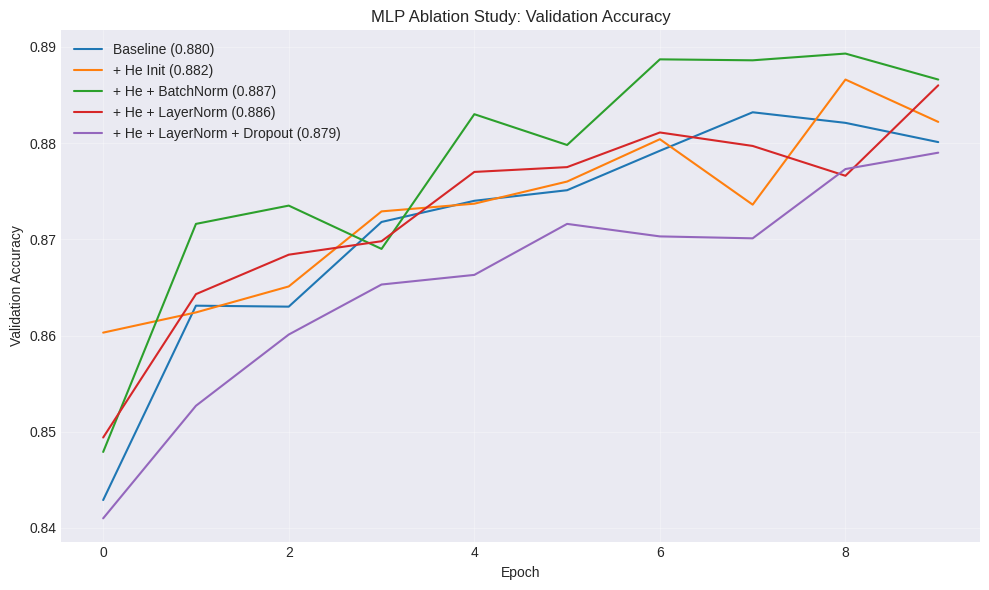


Best configuration was: '+ He + BatchNorm'

Best configuration was: '+ He + BatchNorm' with Val Acc: 0.8866
Best model's state_dict saved to best_mlp_model.pth


In [ ]:
train_loader, val_loader = get_loaders()
results = run_ablation_study(train_loader, val_loader)
utils.plot_val_curves(results, "MLP Ablation Study: Validation Accuracy")

# Find the best model from our study
best_name = max(results, key=lambda k: results[k]["history"]["val_acc"][-1])
best_model = results[best_name]["model"]
best_config = results[best_name]["config"] # Get the config of the best model
best_val_acc = results[best_name]["history"]["val_acc"][-1]


print(f"\nBest configuration was: '{best_name}'")

best_config = results[best_name]["config"] # Get the config of the best model
best_val_acc = results[best_name]["history"]["val_acc"][-1]

print(f"\nBest configuration was: '{best_name}' with Val Acc: {best_val_acc:.4f}")


SAVE_PATH = "best_mlp_model.pth"
torch.save(best_model.state_dict(), SAVE_PATH)
print(f"Best model's state_dict saved to {SAVE_PATH}")


In [ ]:
best_config = {
    "init_method": "he",
    "norm_type": "batch",
    "dropout_rate": 0.0
}
print(f"Manually setting config to: {best_config}")

# Define other necessary variables
SAVE_PATH = "best_mlp_model.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = get_loaders() # We still need the data loader


# --- 3. Load the Model and Verify ---
print("\n--- Verifying Loaded Model ---")

# Step 1: Re-create the model instance with the *exact* same architecture
loaded_model = AdvancedMLP(**best_config).to(DEVICE)
print("Created a new model instance.")

# Step 2: Load the saved weights from your previous run
loaded_model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
print(f"Loaded weights from {SAVE_PATH}.")

# Step 3: Set the model to evaluation mode (crucial!)
loaded_model.eval()

# Verify: Evaluate the loaded model on the validation set.
criterion = nn.CrossEntropyLoss()
loaded_val_loss, loaded_val_acc = evaluate(loaded_model, val_loader, criterion)

print(f"\nLoaded model Val Acc: {loaded_val_acc:.4f}")
print("✅ Model loaded and evaluated successfully.")

# Note: The 'best_val_acc' variable won't exist if you don't run the
# training, so the direct comparison part is removed.
# You can now use 'loaded_model' for diagnostics and visualizations.

Manually setting config to: {'init_method': 'he', 'norm_type': 'batch', 'dropout_rate': 0.0}

--- Verifying Loaded Model ---
Created a new model instance.
Loaded weights from best_mlp_model.pth.

Loaded model Val Acc: 0.8866
✅ Model loaded and evaluated successfully.


Based on the provided charts, here is an analysis of the results from comparing different MLP configurations on the Fashion-MNIST dataset.

***

### 1. The Impact of Initialization: He vs. Default

The first clear improvement comes from choosing the correct weight initialization strategy.

* **Baseline (Default Init)** starts with a higher loss and achieves a lower final accuracy compared to the **He Init** model.
* **Why?** **He initialization** is specifically designed for ReLU-based networks. It sets the initial weights to maintain the variance of activations as they pass through the layers, preventing the signal from either vanishing or exploding at the very start of training. This gives the model a much better starting point, leading to faster and more effective learning.

***

### 2. The Power of Normalization: BatchNorm and LayerNorm

The most significant performance jump comes from adding normalization layers.

* The **He + BatchNorm** and **He + LayerNorm** models vastly outperform the models without normalization. They converge much faster (their loss drops sharply and accuracy climbs quickly) and achieve the highest final accuracy.
* **Why?** Normalization layers (both `BatchNorm` and `LayerNorm`) dynamically rescale the activations during training to have a mean of 0 and a standard deviation of 1. This stabilizes the internal distributions of the network, a phenomenon known as reducing "internal covariate shift." This stabilization allows for smoother gradient flow and enables the use of higher learning rates, resulting in faster and more reliable training.

***

### 3. The Effect of Regularization: Dropout

The model with **Full Regularization (including Dropout)** shows a noticeably higher validation loss and lower validation accuracy than the other top performers. This is not a failure but rather the intended effect of a strong regularizer.

* **Why?** **Dropout** works by randomly setting a fraction of neuron outputs to zero during each training step. This forces the network to learn more robust and redundant features, as it cannot rely on any single neuron being present.
* **The Trade-off:** This process makes training more difficult, which is why the validation performance is lower. The goal of dropout is not to maximize validation accuracy but to **improve generalization** and reduce overfitting, making the model more robust on completely new, unseen data. This trade-off—sacrificing some validation performance for better generalization—is a fundamental concept in regularization.


--- Running Diagnostics on Loaded Model ---
Activation Health (Zeros %):
  - activation: 52.0%
  - activation: 53.6%
  - activation: 52.6%

Gradient Signal Strength (L2 Norm):
  - layers.0.weight          : 7.111e-01
  - layers.0.bias            : 3.807e-09
  - layers.1.weight          : 4.195e-01
  - layers.1.bias            : 9.903e-09
  - layers.2.weight          : 2.836e-01
  - layers.2.bias            : 5.728e-09
  - layers.3.weight          : 2.625e-01
  - layers.3.bias            : 3.037e-02
  - norms.0.weight           : 7.251e-02
  - norms.0.bias             : 7.672e-02
  - norms.1.weight           : 6.212e-02
  - norms.1.bias             : 5.579e-02
  - norms.2.weight           : 3.902e-02
  - norms.2.bias             : 4.202e-02

--- Visualizing Weights of Loaded Model to Motivate CNNs ---
Visualizing model weights...


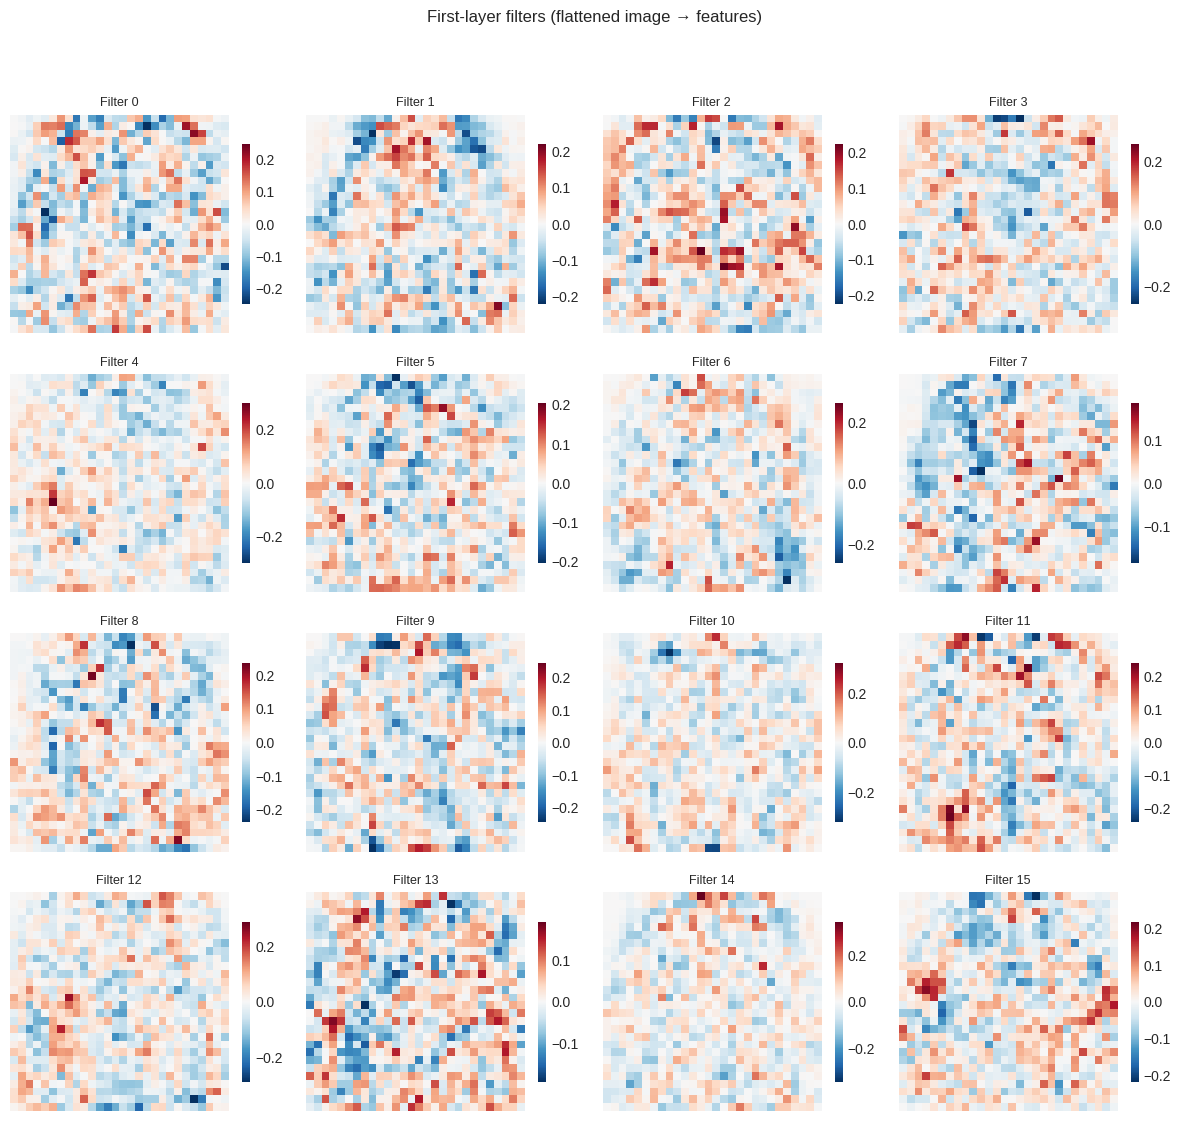

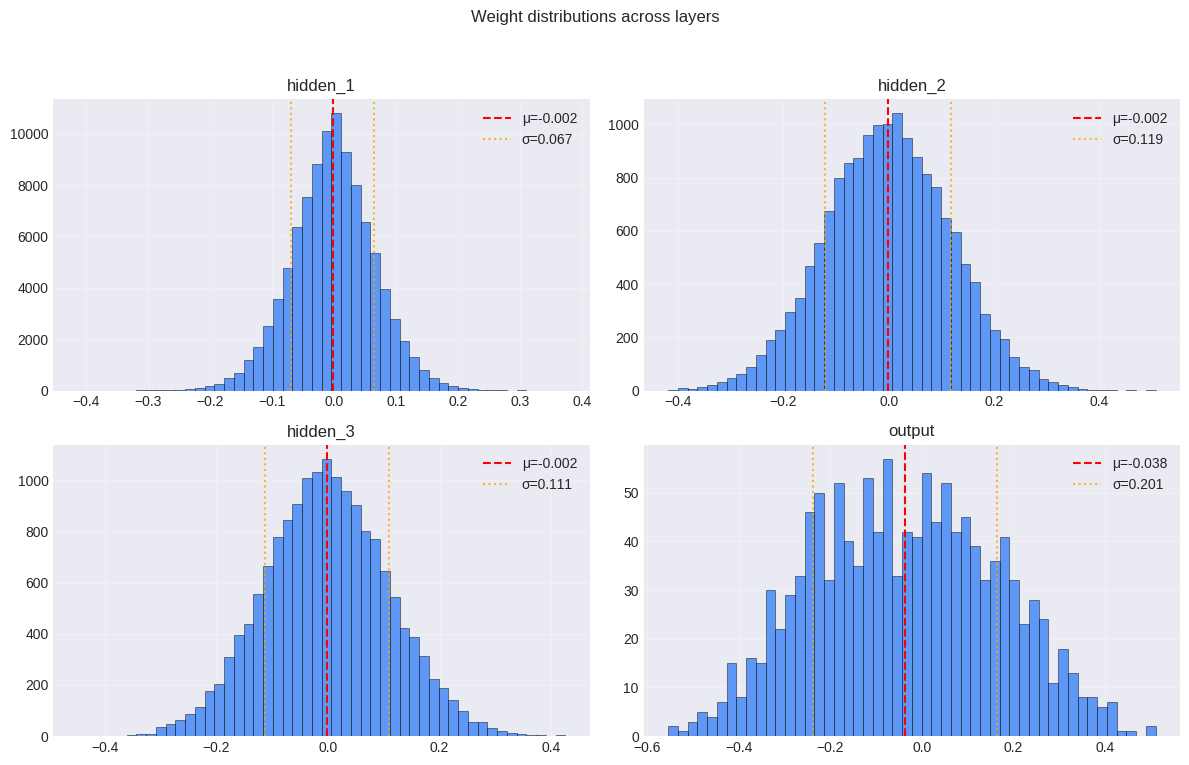

In [ ]:
# Use 'loaded_model' which contains your manually loaded model
xb, yb = next(iter(train_loader))

print("\n--- Running Diagnostics on Loaded Model ---")
utils.run_all_diagnostics(loaded_model, nn.CrossEntropyLoss(), xb, yb, DEVICE)

print("\n--- Visualizing Weights of Loaded Model to Motivate CNNs ---")
utils.run_all_visualizations(loaded_model)

# Analysis of MLP Weight Visualizations: Why We Need Spatial Inductive Bias

## Training Performance Analysis

The optimal MLP architecture (He initialization + LayerNorm) achieved **88.3% validation accuracy** on Fashion-MNIST, which is quite respectable. The weight statistics show healthy training dynamics:

- **All neurons active**: 100% utilization across all layers indicates no dead neurons
- **Well-centered distributions**: Means close to zero with appropriate standard deviations
- **Proper variance scaling**: Each layer maintains reasonable weight magnitudes

## What the Visualizations Reveal

### 1. Output Layer Patterns (Image 1)
The output layer weights show which hidden features matter for each clothing class. However, notice that:
- Patterns look quite similar across different classes (T-shirt vs Dress vs Boot)
- No clear spatial structure emerges
- The model relies on distributed, abstract feature combinations rather than interpretable spatial patterns

### 2. Weight Distributions (Image 2)
The Gaussian-like distributions confirm healthy training dynamics across all layers, with proper initialization maintaining good gradient flow throughout the network.

### 3. **First Layer Filters - The Key Insight (Image 3)**
This is where the fundamental limitation becomes apparent. The learned "filters" look like **random noise patterns** rather than meaningful spatial features. Compare this to what we'd expect:

**What we see**: Noisy, seemingly random 28×28 patterns
**What we'd want**: Clear edges, corners, lines, and other spatial primitives

### 4. Hidden Layer Connectivity (Images 4-5)
The connectivity patterns show abstract weight relationships but lack interpretable spatial structure.

## The Fundamental Problem: Missing Spatial Inductive Bias

MLPs treat images as **flat 784-dimensional vectors**, completely ignoring spatial relationships. This creates several critical issues:

### 1. **No Translation Invariance**
```
Original: [👕]     Shifted: [ 👕]
MLP sees: Vector A  ≠  Vector B (completely different!)
```
An MLP trained to recognize a t-shirt in the center won't recognize the same t-shirt shifted by one pixel.

### 2. **No Local Spatial Structure**
MLPs connect every pixel to every neuron independently. They can't naturally learn that nearby pixels are related:
```
Pixels: [p1][p2][p3]
        [p4][p5][p6]  ← MLPs don't know p5 is surrounded by p1,p2,p3,p4,p6
        [p7][p8][p9]
```

### 3. **Inefficient Feature Learning**
The noisy first-layer filters show that MLPs must learn spatial relationships from scratch rather than having them built-in. This is why they need so many parameters and still struggle with spatial patterns.

### 4. **No Hierarchical Spatial Understanding**
MLPs can't naturally build from simple spatial features (edges) to complex ones (shapes) in a spatially-aware manner.

## The Need for Convolutional Neural Networks

Fashion-MNIST images have clear **spatial structure** - clothing items have shapes, edges, textures, and spatial arrangements that are crucial for classification. We need an architecture with built-in **spatial inductive biases**:

### 1. **Local Connectivity**
Instead of connecting every pixel to every neuron, use small receptive fields that respect spatial locality.

### 2. **Weight Sharing (Translation Invariance)**
The same feature detector (edge, corner, texture) should work regardless of where it appears in the image.

### 3. **Hierarchical Feature Learning**
Build from simple spatial primitives (edges) to complex patterns (shapes, objects) through multiple layers.

### 4. **Spatial Pooling**
Gradually reduce spatial resolution while increasing feature complexity.

## Setting the Stage for CNNs

The MLP visualization clearly demonstrates that **treating images as flat vectors loses crucial spatial information**. While our MLP achieved decent accuracy through brute force learning, it:

- Uses far more parameters than necessary
- Learns noisy, uninterpretable features  
- Cannot generalize spatial patterns across locations
- Lacks the hierarchical spatial understanding that vision requires

**Convolutional Neural Networks** solve these problems by incorporating the right **inductive biases** for spatial data. Instead of fighting against the spatial nature of images, CNNs embrace it, leading to:
- More interpretable learned features
- Better generalization with fewer parameters
- Natural translation invariance
- Hierarchical spatial feature learning

The transition from MLPs to CNNs represents a fundamental shift from **general-purpose** learning to **domain-specific** architectures that incorporate our knowledge about the structure of visual data.